In [1]:
import email.policy
from email.parser import BytesParser
import os
from concurrent.futures import ThreadPoolExecutor
from functools import partial

In [2]:
import sys

sys.path.append("../Handlers")

JSON_WRITE_MODE = "overwrite"

import preprocessing

[nltk_data] Downloading package punkt to E:/nltk...
[nltk_data]   Package punkt is already up-to-date!


# Testing extracting on a file

In [3]:
paths = [
    "./easy_ham/easy_ham",
    "./hard_ham/hard_ham",
    "./spam_2/spam_2"
]

with open("./spam_2/spam_2/00004.bdcc075fa4beb5157b5dd6cd41d8887b", "rb") as file:
    msg = BytesParser(policy=email.policy.default).parse(file)

print("Receive")
print(msg.get_all("Received"))
print("From")
print(msg.get_all("From"))

Receive
['from mandark.labs.netnoteinc.com ([213.105.180.140]) by    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g4GA3qe29480 for    <jm@jmason.org>; Thu, 16 May 2002 11:03:52 +0100', 'from webnote.net (mail.webnote.net [193.120.211.219]) by    mandark.labs.netnoteinc.com (8.11.2/8.11.2) with ESMTP id g4GA3oD28650 for    <jm@netnoteinc.com>; Thu, 16 May 2002 11:03:51 +0100', 'from webcust2.hightowertech.com (webcust2.hightowertech.com    [216.41.166.100]) by webnote.net (8.9.3/8.9.3) with ESMTP id BAA11067 for    <jm@netnoteinc.com>; Thu, 16 May 2002 01:58:00 +0100', 'from html ([199.35.236.73]) by webcust2.hightowertech.com  with    Microsoft SMTPSVC(5.5.1877.197.19); Wed, 15 May 2002 13:50:57 -0700']
From
['jordan23@mailexcite.com']


<code>body = msg.get_body(preferencelist=("html"))</code>

<code>if body:</code>

<code style="margin-left: 1cm">payload = body.get_payload(decode=True)</code>

<code style="margin-left: 1cm">charset = body.get_content_charset() or "utf-8"</code>

<code style="margin-left: 1cm">try:</code>

<code style="margin-left: 2cm">extracted_body = payload.decode(charset, errors="replace")</code>

<code style="margin-left: 1cm">except:</code>

<code style="margin-left: 2cm">extracted_body = payload.decode("utf-8", errors="replace")</code>

<code>from bs4 import BeautifulSoup</code>

<code>clean_text = BeautifulSoup(extracted_body, "html.parser").get_text()</code>

<code>clean_text</code>

# Extract all features from all emails

In [4]:
from bs4 import BeautifulSoup

def extract_spam_assassin_features(file, path):
    if path == "./easy_ham/easy_ham":
        label = 0
    elif path == "./hard_ham/hard_ham":
        label = 0
    elif path == "./spam_2/spam_2":
        label = 1
    else:
        raise ValueError("Path is not included in the function. Please upgrading the function for more paths.")

    with open(file, "rb") as file:
        e = BytesParser(policy=email.policy.default).parse(file)

    part = e.get_body(preferencelist=("plain", "html"))

    if part:
        payload = part.get_payload(decode=True)
        charset = part.get_content_charset()
        try:
            body = payload.decode(charset, errors="replace")
        except:
            body = payload.decode("utf-8", errors="replace")

    else:
        payload = e.get_payload(decode=True)
        body = payload.decode("utf-8", errors="replace") if payload else ""

    body = BeautifulSoup(body, "html.parser").get_text()

    return {
        "Subject": e.get("Subject"),
        "Date": e.get("Date"),
        "From": e.get_all("From"),
        "To": e.get_all("To"),
        "Received": e.get_all("Received"),
        "Content-Type": e.get_content_type(),
        "Body": body,
        "Is_spam": label
    }    

In [5]:
overall_data = []

for p in paths:

    extract_spam = partial(
        extract_spam_assassin_features,
        path=p
    )

    with ThreadPoolExecutor(max_workers=5) as executor:
        data = list(executor.map(extract_spam, [os.path.join(p, path) for path in os.listdir(p)]))

    overall_data.extend(data)

C:\Users\admin\AppData\Local\Temp\ipykernel_1548\2871712314.py:30: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  body = BeautifulSoup(body, "html.parser").get_text()
C:\Users\admin\AppData\Local\Temp\ipykernel_1548\2871712314.py:30: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  body = BeautifulSoup(body, "html.parser").get_text()


In [6]:
overall_data[0]

{'Subject': 'Re: New Sequences Window',
 'Date': 'Thu, 22 Aug 2002 18:26:25 +0700',
 'From': ['Robert Elz <kre@munnari.OZ.AU>'],
 'To': ['Chris Garrigues <cwg-dated-1030377287.06fa6d@DeepEddy.Com>'],
 'Received': ['from localhost (localhost [127.0.0.1])\tby phobos.labs.netnoteinc.com (Postfix) with ESMTP id D03E543C36\tfor <zzzz@localhost>; Thu, 22 Aug 2002 07:36:16 -0400 (EDT)',
  'from phobos [127.0.0.1]\tby localhost with IMAP (fetchmail-5.9.0)\tfor zzzz@localhost (single-drop); Thu, 22 Aug 2002 12:36:16 +0100 (IST)',
  'from listman.example.com (listman.example.com [66.187.233.211]) by    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g7MBYrZ04811 for    <zzzz-exmh@example.com>; Thu, 22 Aug 2002 12:34:53 +0100',
  'from listman.example.com (localhost.localdomain [127.0.0.1]) by    listman.redhat.com (Postfix) with ESMTP id 8386540858; Thu, 22 Aug 2002    07:35:02 -0400 (EDT)',
  'from int-mx1.corp.example.com (int-mx1.corp.example.com    [172.16.52.254]) by listman.redhat.com (P

In [7]:
import pandas as pd

df = pd.DataFrame(overall_data)

if not os.path.exists(
    "./SpamAssassin.csv"
):
    df.to_csv("SpamAssassin.csv", index=False)
else:
    old_df = pd.read_csv("SpamAssassin.csv")
    rows = len(old_df)
    columns = len(old_df.columns)
    if len(df) != rows or len(df.columns) != columns:
        df.to_csv("SpamAssassin.csv", index=False)

In [8]:
csv_file = pd.read_csv("./SpamAssassin.csv")

csv_file.head()

,Subject,Date,From,To,Received,Content-Type,Body,Is_spam
0,Re: New Sequences Window,"Thu, 22 Aug 2002 18:26:25 +0700",['Robert Elz <kre@munnari.OZ.AU>'],['Chris Garrigues <cwg-dated-1030377287.06fa6d...,['from localhost (localhost [127.0.0.1])\tby p...,text/plain,"Date: Wed, 21 Aug 2002 10:54:46 -05...",0
1,[zzzzteana] RE: Alexander,"Thu, 22 Aug 2002 12:46:18 +0100",['Steve Burt <Steve_Burt@cursor-system.com>'],"['""\'zzzzteana@yahoogroups.com\'"" <zzzzteana@y...",['from localhost (localhost [127.0.0.1])\tby p...,text/plain,"Martin A posted:\nTassos Papadopoulos, the Gre...",0
2,[zzzzteana] Moscow bomber,"Thu, 22 Aug 2002 13:52:38 +0100",['Tim Chapman <timc@2ubh.com>'],['zzzzteana <zzzzteana@yahoogroups.com>'],['from localhost (localhost [127.0.0.1])\tby p...,text/plain,Man Threatens Explosion In Moscow \n\nThursday...,0
3,[IRR] Klez: The Virus That Won't Die,"Thu, 22 Aug 2002 09:15:25 -0400",['Monty Solomon <monty@roscom.com>'],['undisclosed-recipient:;'],['from localhost (localhost [127.0.0.1])\tby p...,text/plain,Klez: The Virus That Won't Die\n \nAlready the...,0
4,Re: Insert signature,"Thu, 22 Aug 2002 23:36:32 +1000",['Tony Nugent <tony@linuxworks.com.au>'],['Exmh Users Mailing List <exmh-users@example....,['from localhost (localhost [127.0.0.1])\tby p...,text/plain,"On Wed Aug 21 2002 at 15:46, Ulises Ponce wrot...",0


In [9]:
csv_file["Is_spam"].value_counts()

0    2801
1    1397
Name: Is_spam, dtype: int64

# Testing the patterns

In [10]:
from spam_email_patterns import date_patterns, time_pattern, url_patterns, phone_number_pattern, email_pattern
import re

test_string = csv_file["Body"][0]
print(test_string)

print(re.findall(date_patterns, test_string))

print(re.findall(time_pattern, test_string))

print(re.findall(url_patterns, test_string))

print(re.findall(phone_number_pattern, test_string))

print(re.findall(email_pattern, test_string))

    Date:        Wed, 21 Aug 2002 10:54:46 -0500
    From:        Chris Garrigues 
    Message-ID:  <1029945287.4797.TMDA@deepeddy.vircio.com>


  | I can't reproduce this error.

For me it is very repeatable... (like every time, without fail).

This is the debug log of the pick happening ...

18:19:03 Pick_It {exec pick +inbox -list -lbrace -lbrace -subject ftp -rbrace -rbrace} {4852-4852 -sequence mercury}
18:19:03 exec pick +inbox -list -lbrace -lbrace -subject ftp -rbrace -rbrace 4852-4852 -sequence mercury
18:19:04 Ftoc_PickMsgs {{1 hit}}
18:19:04 Marking 1 hits
18:19:04 tkerror: syntax error in expression "int ...

Note, if I run the pick command by hand ...

delta$ pick +inbox -list -lbrace -lbrace -subject ftp -rbrace -rbrace  4852-4852 -sequence mercury
1 hit

That's where the "1 hit" comes from (obviously).  The version of nmh I'm
using is ...

delta$ pick -version
pick -- nmh-1.0.4 [compiled on fuchsia.cs.mu.OZ.AU at Sun Mar 17 14:55:56 ICT 2002]

And the relevant part of my

# Preprocess all text

In [11]:
preprocession = partial(
    preprocessing.preprocess_text,
    remove_numbers=True
)

preprocessed_data = csv_file["Body"].apply(preprocession)
preprocessed_data

0       [date, DATE, TIME, chris, garrigues, messageid...
1       [martin, posted, tassos, papadopoulos, greek, ...
2       [man, threatens, explosion, moscow, thursday, ...
3       [klez, virus, wont, die, already, prolific, vi...
4       [wed, DATE, TIME, ulises, ponce, wrote, hi, co...
                              ...                        
4193    [preferred, nonsmoker, doctor, ordered, case, ...
4194    [dear, subscriber, could, show, way, get, visi...
4195    [midsummer, customer, appreciation, sale, expr...
4196    [attnsirmadan, strictly, confidential, pleased...
4197    [mv, efaeefcdfdcbaPHONENUMefaeefcdfdcba, mv, e...
Name: Body, Length: 4198, dtype: object

In [12]:
import itertools

combined = list(itertools.chain.from_iterable(preprocessed_data))
len(combined)

644408

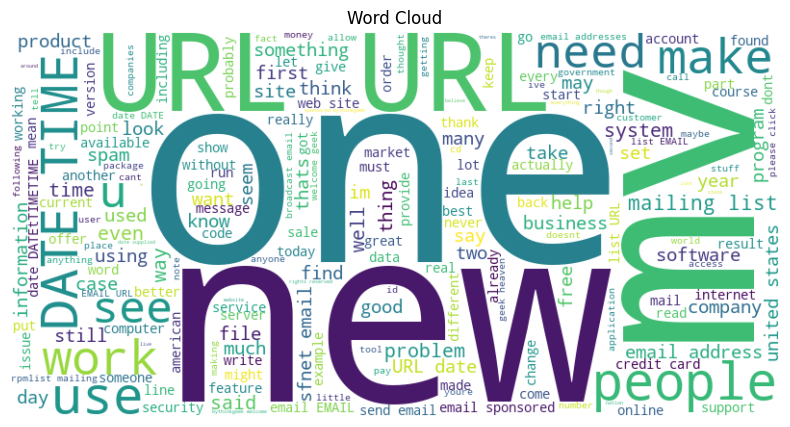

In [13]:
preprocessing.visualize_wordcloud(combined)

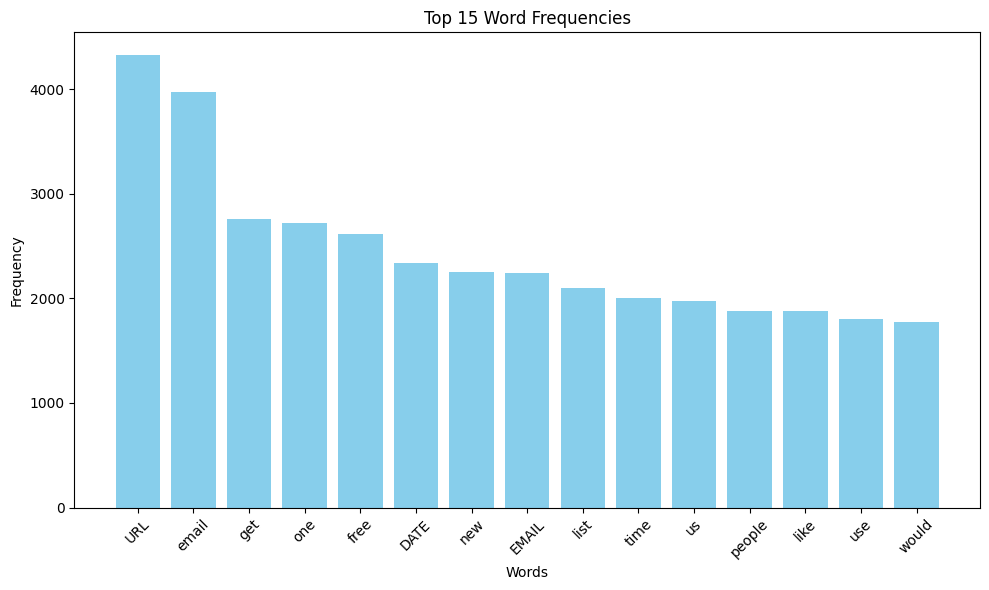

In [14]:
from collections import Counter
import matplotlib.pyplot as plt

counter = Counter(combined)
most_common = counter.most_common(15)

words, counts = zip(*most_common)

plt.figure(figsize=(10, 6))
plt.bar(words, counts, color='skyblue')
plt.title("Top 15 Word Frequencies")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Evaluate different models

In [15]:
from traintest import ClassificationModel, get_classification_models, add_to_json_array
from functools import partial
from concurrent.futures import ThreadPoolExecutor

metric_results = []

def t_and_e(model, X, y, dataset_name):
    classification_model = ClassificationModel(model, dataset_name)
    classification_model.train_with_epochs(X, y, save_model=True, test_size=0.1, valid_size=0.1, epochs=5)
    print(f"{model.__class__.__name__} classification report")
    classification_model.plot_train_val_accuracy_after_epochs(xlabel="Epochs", ylabel="Accuracy", save_plot=True)
    metrics = classification_model.evaluate(detailed=True)
    metric_results.append(metrics)
    print(metrics)
    print("\n")

def train_and_evaluate_model(X, y, dataset_name, m, threading=True):
    print(f"{dataset_name} classification report")
    print("=========================================")
    
    train_eval = partial(
        t_and_e,
        X=X,
        y=y,
        dataset_name=dataset_name,
    )

    if threading:
        with ThreadPoolExecutor(max_workers=3) as executor:
            executor.map(train_eval, m)
    else:
        for model in m:
            train_eval(model)

## Stemming + CountVectorizer

In [16]:
model = get_classification_models()

In [17]:
spam_assassin_stemming = preprocessed_data.apply(preprocessing.stemming)
spam_assassin_stemming_countvec = preprocessing.vectorizing(spam_assassin_stemming, "countvectorizer")

spam_assassin_stemmed_countvec classification report
BernoulliNB classification report
MultinomialNB classification report


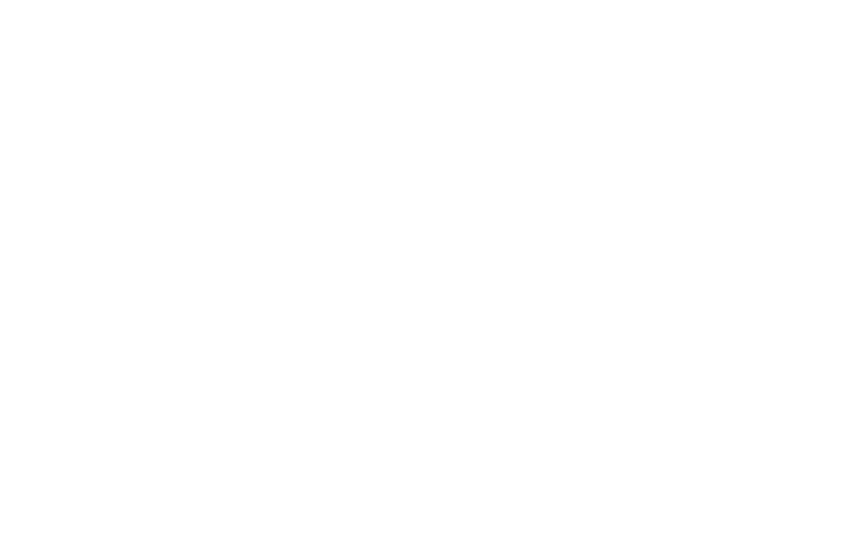

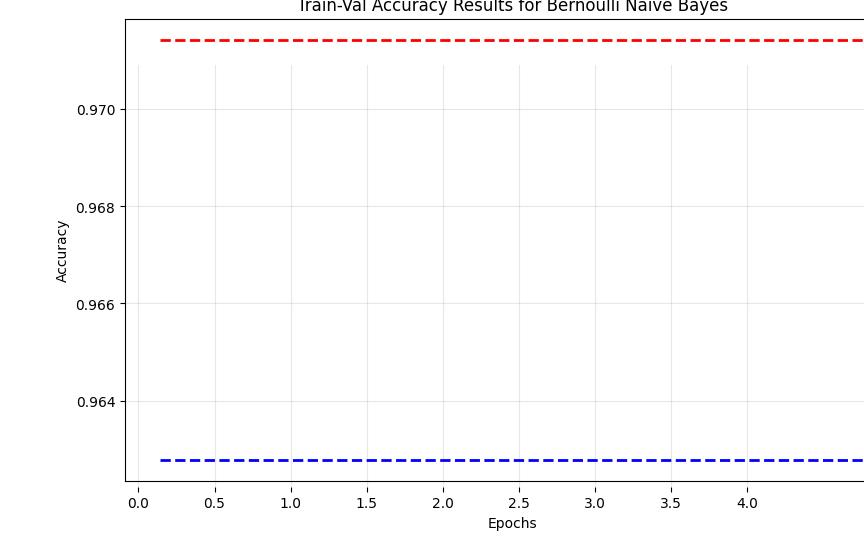

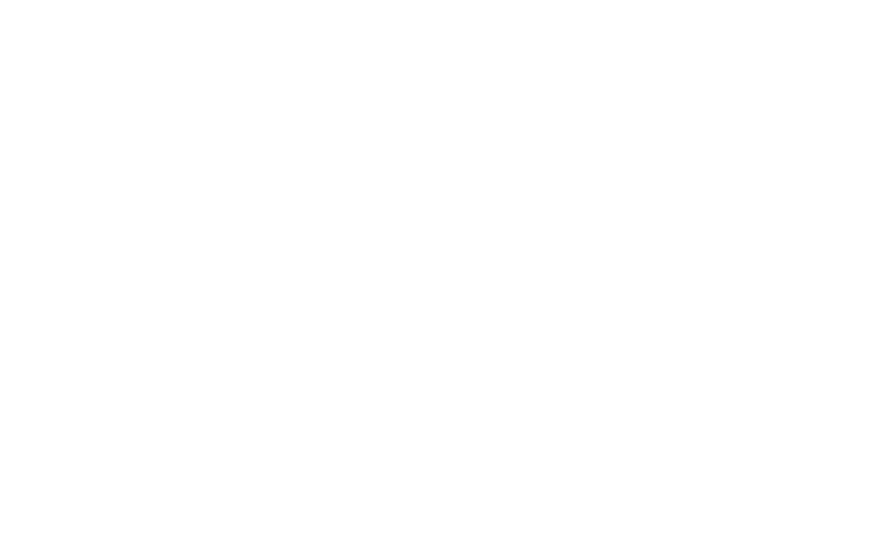

{'dataset': 'spam_assassin_stemmed_countvec', 'model': 'Bernoulli Naive Bayes', 'type': 'normal', 'metrics': {'accuracy': 0.9404761904761905, 'weighted_precision': 0.9419603174603175, 'wighted_recall': 0.9404761904761905, 'weighted_f1': 0.9393753470179577, 'macro_precision': 0.9483333333333334, 'macro_recall': 0.9162905264243894, 'macro_f1': 0.9299210443766643, 'roc_auc': 0.9162905264243892}, 'confusion_matrix': array([[279,   4],
       [ 21, 116]], dtype=int64)}




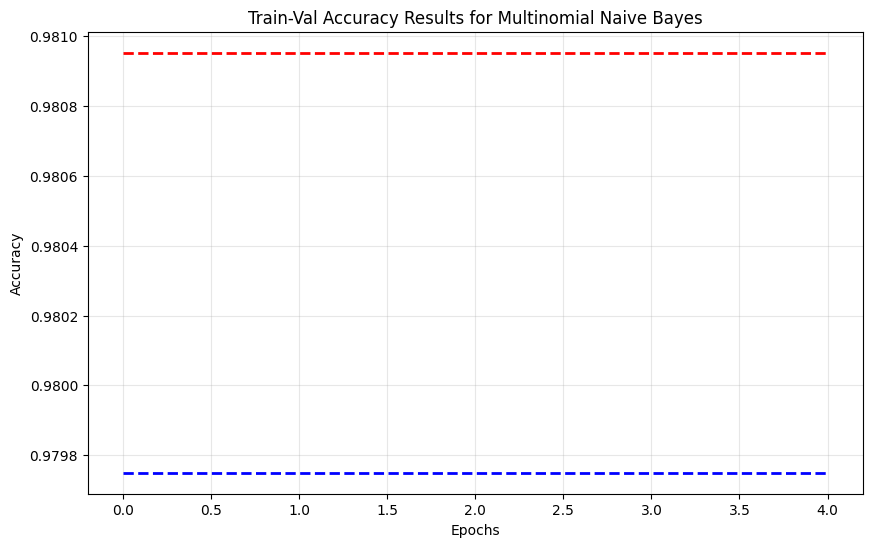

{'dataset': 'spam_assassin_stemmed_countvec', 'model': 'Multinomial Naive Bayes', 'type': 'normal', 'metrics': {'accuracy': 0.9571428571428572, 'weighted_precision': 0.9572555018970748, 'wighted_recall': 0.9571428571428572, 'weighted_f1': 0.9567970448770009, 'macro_precision': 0.9582833852793096, 'macro_recall': 0.9437208222640634, 'macro_f1': 0.9504859710251239, 'roc_auc': 0.9437208222640634}, 'confusion_matrix': array([[278,   5],
       [ 13, 124]], dtype=int64)}


DecisionTreeClassifier classification report


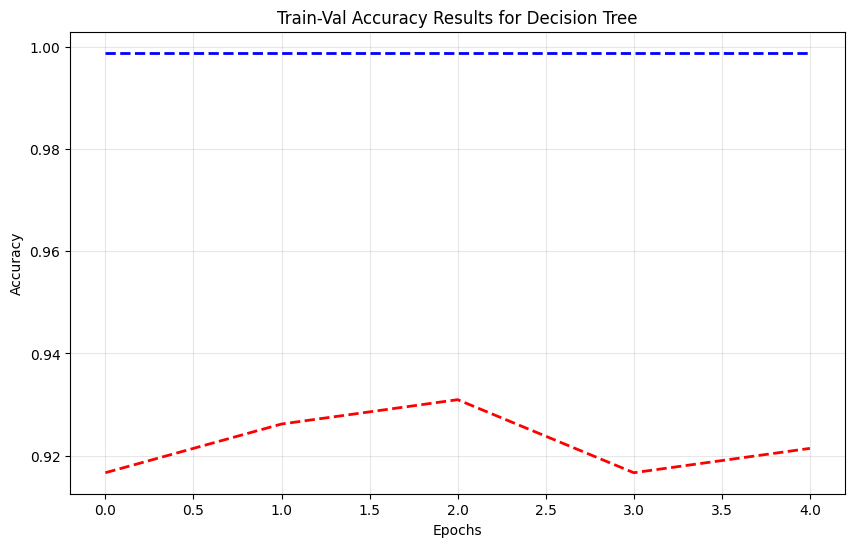

{'dataset': 'spam_assassin_stemmed_countvec', 'model': 'Decision Tree', 'type': 'normal', 'metrics': {'accuracy': 0.9333333333333333, 'weighted_precision': 0.9336269063041382, 'wighted_recall': 0.9333333333333333, 'weighted_f1': 0.9334566759173605, 'macro_precision': 0.9229114928697612, 'macro_recall': 0.9260529777410951, 'macro_f1': 0.9244526672833796, 'roc_auc': 0.9260529777410951}, 'confusion_matrix': array([[268,  15],
       [ 13, 124]], dtype=int64)}


AdaBoostClassifier classification report


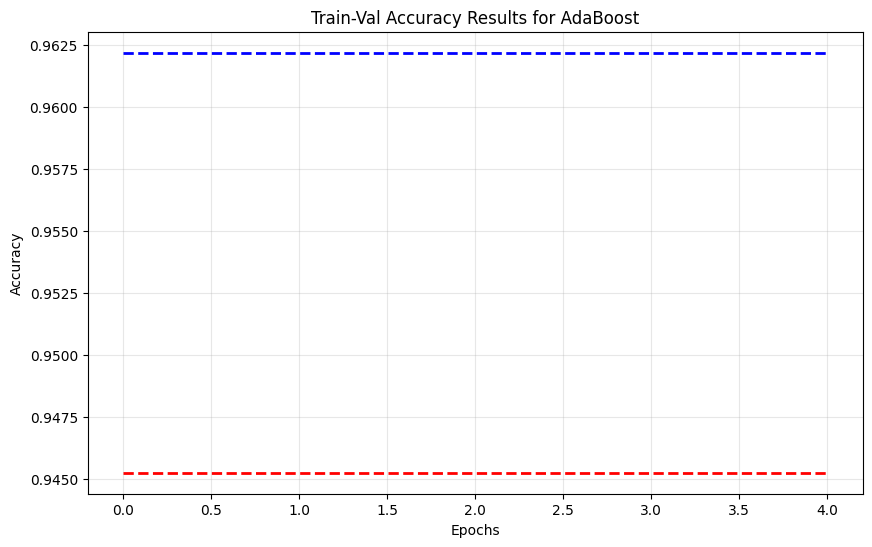

{'dataset': 'spam_assassin_stemmed_countvec', 'model': 'AdaBoost', 'type': 'normal', 'metrics': {'accuracy': 0.9428571428571428, 'weighted_precision': 0.9426171546301503, 'wighted_recall': 0.9428571428571428, 'weighted_f1': 0.9425171843082291, 'macro_precision': 0.9396972978684064, 'macro_recall': 0.9293544143818834, 'macro_f1': 0.934244859617994, 'roc_auc': 0.9293544143818833}, 'confusion_matrix': array([[274,   9],
       [ 15, 122]], dtype=int64)}


LogisticRegression classification report


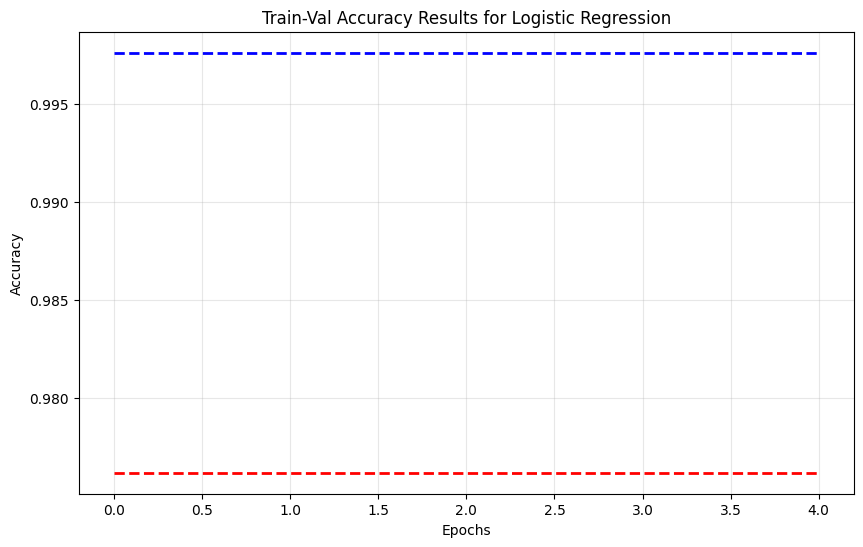

{'dataset': 'spam_assassin_stemmed_countvec', 'model': 'Logistic Regression', 'type': 'normal', 'metrics': {'accuracy': 0.9857142857142858, 'weighted_precision': 0.9857105727281167, 'wighted_recall': 0.9857142857142858, 'weighted_f1': 0.9856869156113148, 'macro_precision': 0.9855750487329434, 'macro_recall': 0.981867890949421, 'macro_f1': 0.9836888980944489, 'roc_auc': 0.981867890949421}, 'confusion_matrix': array([[281,   2],
       [  4, 133]], dtype=int64)}


KNeighborsClassifier classification report


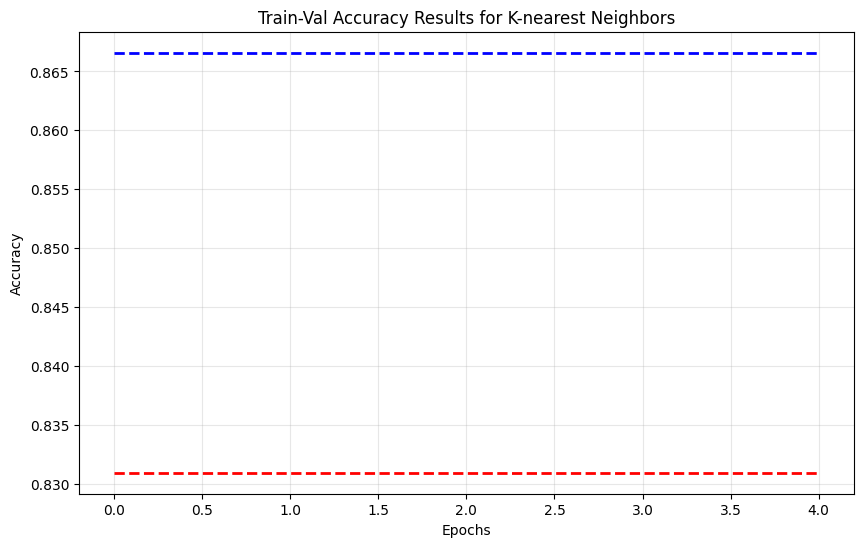

{'dataset': 'spam_assassin_stemmed_countvec', 'model': 'K-nearest Neighbors', 'type': 'normal', 'metrics': {'accuracy': 0.8214285714285714, 'weighted_precision': 0.8715093494932716, 'wighted_recall': 0.8214285714285714, 'weighted_f1': 0.8269642762515423, 'macro_precision': 0.8152647833590698, 'macro_recall': 0.858076913156741, 'macro_f1': 0.8145302315722538, 'roc_auc': 0.858076913156741}, 'confusion_matrix': array([[213,  70],
       [  5, 132]], dtype=int64)}


SGDClassifier classification report
SVC classification report


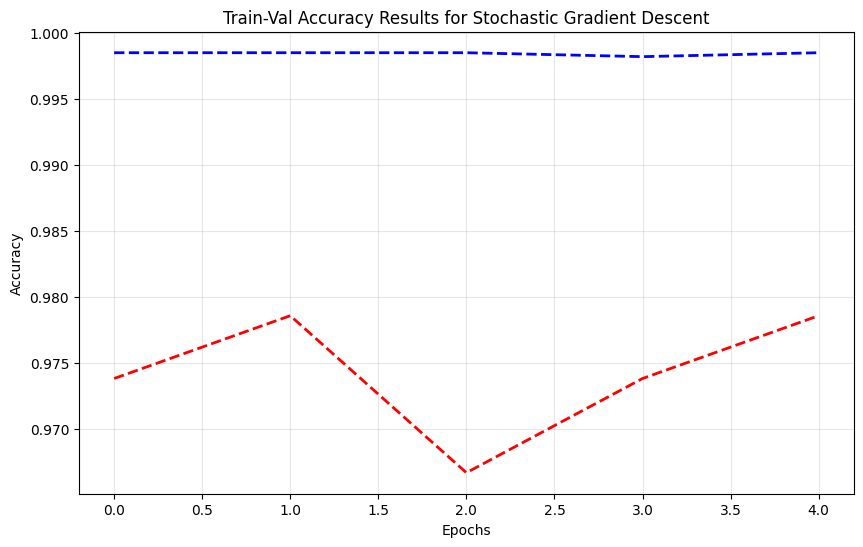

{'dataset': 'spam_assassin_stemmed_countvec', 'model': 'Stochastic Gradient Descent', 'type': 'normal', 'metrics': {'accuracy': 0.9714285714285714, 'weighted_precision': 0.9714285714285714, 'wighted_recall': 0.9714285714285714, 'weighted_f1': 0.9714285714285714, 'macro_precision': 0.967501483067241, 'macro_recall': 0.967501483067241, 'macro_f1': 0.967501483067241, 'roc_auc': 0.9675014830672409}, 'confusion_matrix': array([[277,   6],
       [  6, 131]], dtype=int64)}


Perceptron classification report
{'dataset': 'spam_assassin_stemmed_countvec', 'model': 'SVM', 'type': 'normal', 'metrics': {'accuracy': 0.9285714285714286, 'weighted_precision': 0.9330655204441611, 'wighted_recall': 0.9285714285714286, 'weighted_f1': 0.926395721758625, 'macro_precision': 0.9456835476252952, 'macro_recall': 0.8942766500735085, 'macro_f1': 0.9141782911944202, 'roc_auc': 0.8942766500735085}, 'confusion_matrix': array([[281,   2],
       [ 28, 109]], dtype=int64)}




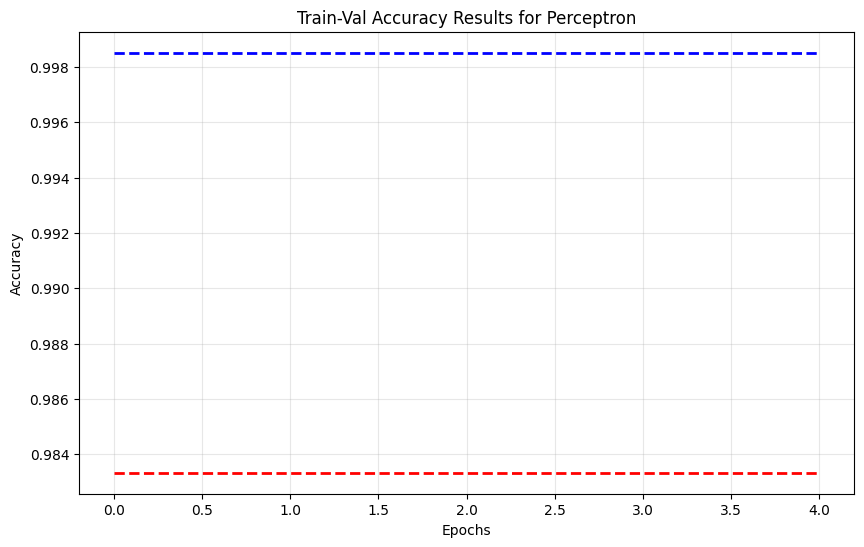

{'dataset': 'spam_assassin_stemmed_countvec', 'model': 'Perceptron', 'type': 'normal', 'metrics': {'accuracy': 0.9714285714285714, 'weighted_precision': 0.9715836481805912, 'wighted_recall': 0.9714285714285714, 'weighted_f1': 0.9714814325360117, 'macro_precision': 0.9659233467318671, 'macro_recall': 0.9693843336514405, 'macro_f1': 0.967622571692877, 'roc_auc': 0.9693843336514406}, 'confusion_matrix': array([[276,   7],
       [  5, 132]], dtype=int64)}


PassiveAggressiveClassifier classification report


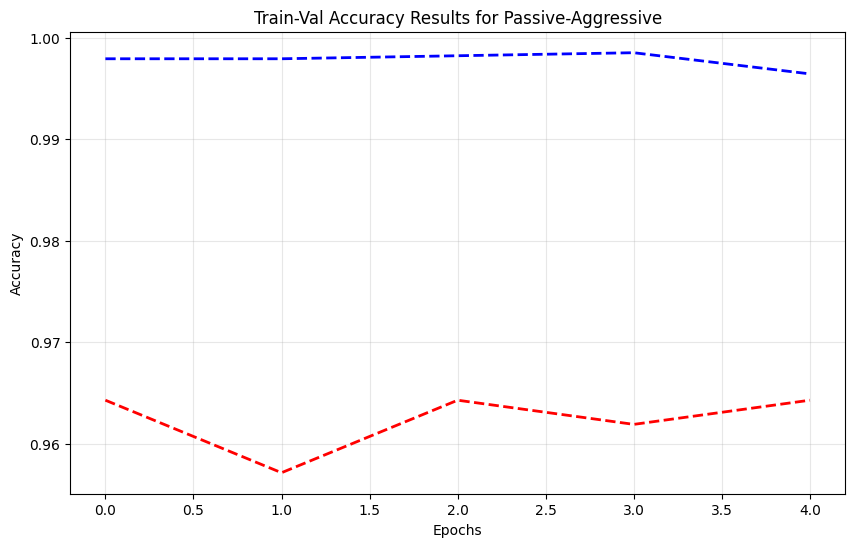

{'dataset': 'spam_assassin_stemmed_countvec', 'model': 'Passive-Aggressive', 'type': 'normal', 'metrics': {'accuracy': 0.9619047619047619, 'weighted_precision': 0.9632040603075085, 'wighted_recall': 0.9619047619047619, 'weighted_f1': 0.9621720357478766, 'macro_precision': 0.9513479623824451, 'macro_recall': 0.9642000464264529, 'macro_f1': 0.9572942881110349, 'roc_auc': 0.9642000464264527}, 'confusion_matrix': array([[271,  12],
       [  4, 133]], dtype=int64)}


RandomForestClassifier classification report


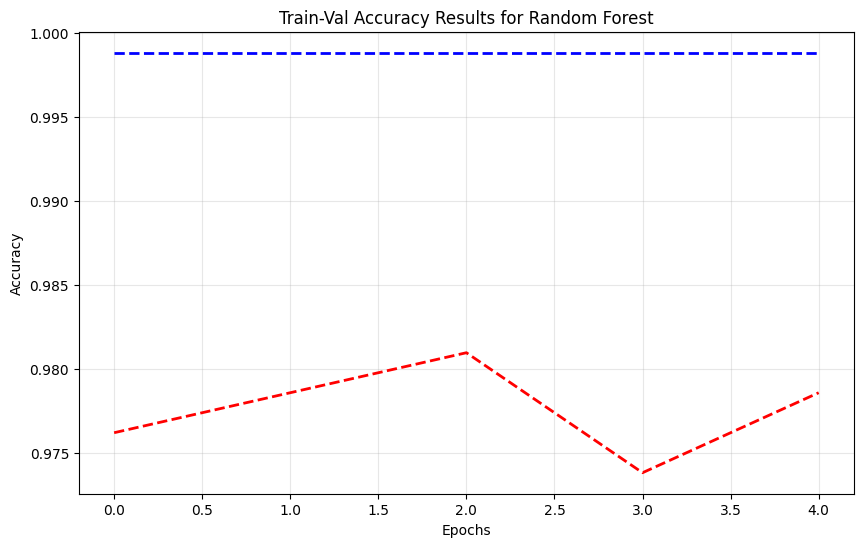

{'dataset': 'spam_assassin_stemmed_countvec', 'model': 'Random Forest', 'type': 'normal', 'metrics': {'accuracy': 0.9761904761904762, 'weighted_precision': 0.9763678259808639, 'wighted_recall': 0.9761904761904762, 'weighted_f1': 0.9760488267950956, 'macro_precision': 0.9785255817639135, 'macro_recall': 0.9672693508034356, 'macro_f1': 0.9726020248408308, 'roc_auc': 0.9672693508034356}, 'confusion_matrix': array([[281,   2],
       [  8, 129]], dtype=int64)}


MLPClassifier classification report


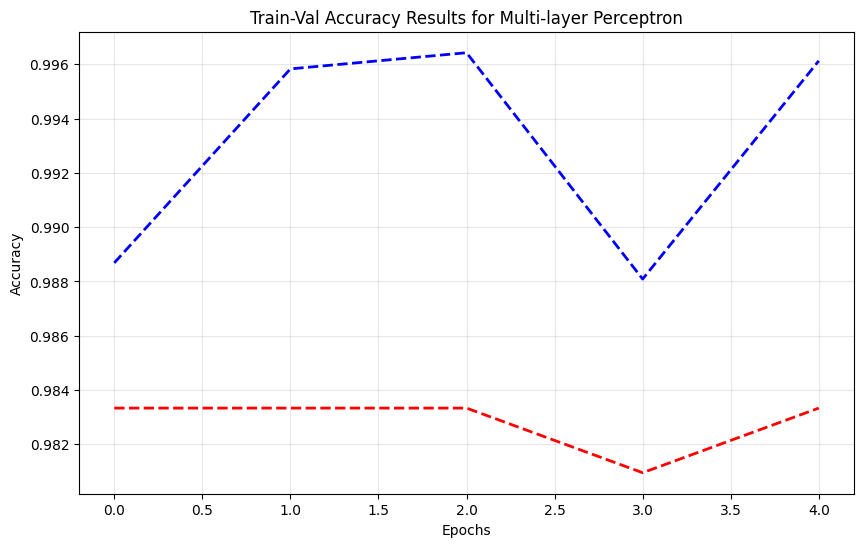

{'dataset': 'spam_assassin_stemmed_countvec', 'model': 'Multi-layer Perceptron', 'type': 'normal', 'metrics': {'accuracy': 0.9880952380952381, 'weighted_precision': 0.988141833291087, 'wighted_recall': 0.9880952380952381, 'weighted_f1': 0.9880607279585222, 'macro_precision': 0.989275649723411, 'macro_recall': 0.9836346754017178, 'macro_f1': 0.9863812346383569, 'roc_auc': 0.9836346754017178}, 'confusion_matrix': array([[282,   1],
       [  4, 133]], dtype=int64)}




In [18]:
train_and_evaluate_model(spam_assassin_stemming_countvec, csv_file["Is_spam"], "spam_assassin_stemmed_countvec", model)
del spam_assassin_stemming_countvec
model = None

## Stemming + TF-IDF

In [19]:
model = get_classification_models()

In [20]:
spam_assassin_stemming_tfidf = preprocessing.vectorizing(spam_assassin_stemming, "tfidf")

spam_assassin_stemmed_tfidf classification report
MultinomialNB classification report
BernoulliNB classification report


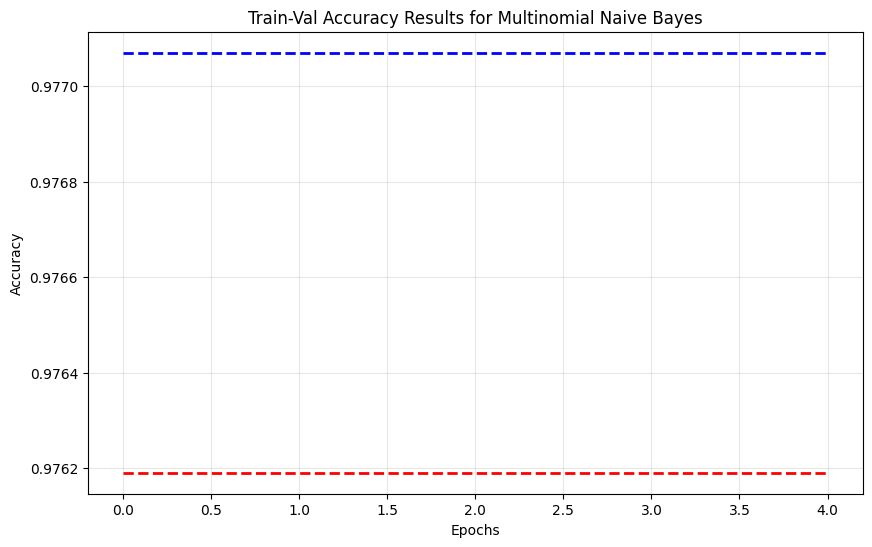

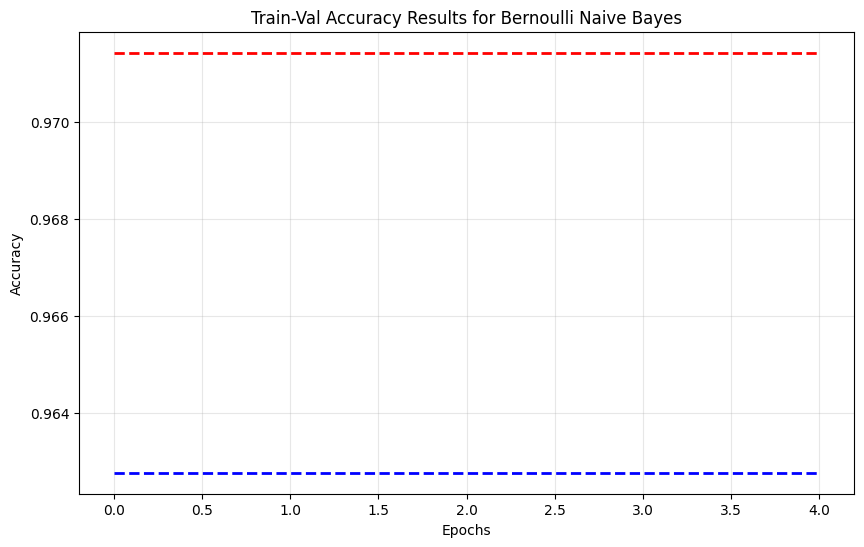

{'dataset': 'spam_assassin_stemmed_tfidf', 'model': 'Multinomial Naive Bayes', 'type': 'normal', 'metrics': {'accuracy': 0.9571428571428572, 'weighted_precision': 0.9575306073088985, 'wighted_recall': 0.9571428571428572, 'weighted_f1': 0.9567031926406926, 'macro_precision': 0.9603611835210017, 'macro_recall': 0.9418379716798638, 'macro_f1': 0.9502840909090908, 'roc_auc': 0.9418379716798638}, 'confusion_matrix': array([[279,   4],
       [ 14, 123]], dtype=int64)}




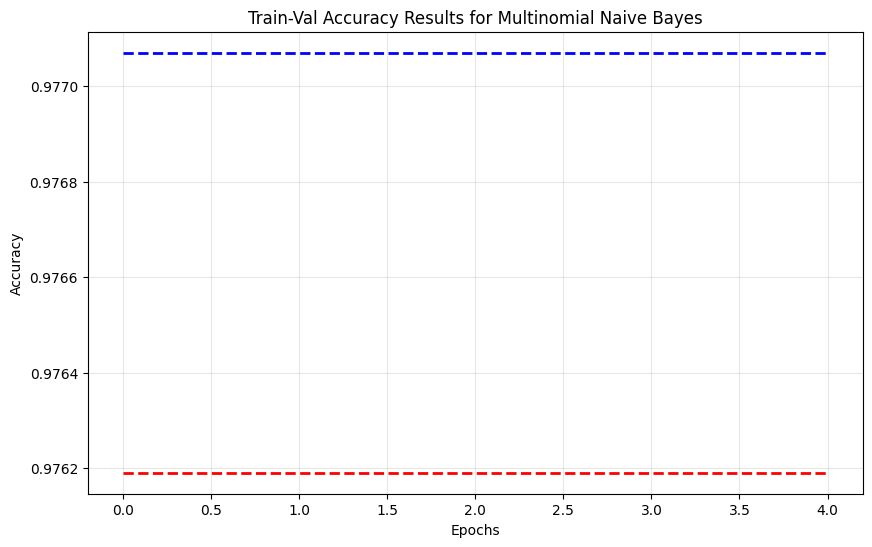

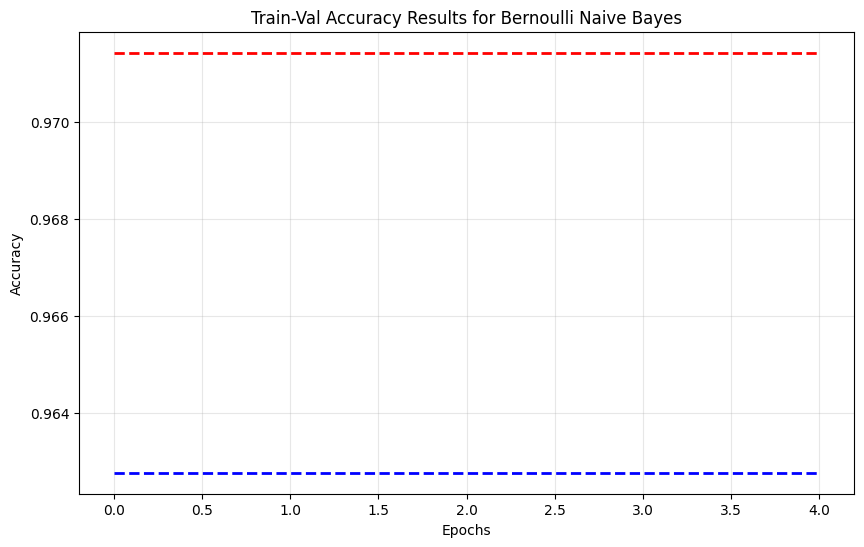

{'dataset': 'spam_assassin_stemmed_tfidf', 'model': 'Bernoulli Naive Bayes', 'type': 'normal', 'metrics': {'accuracy': 0.9404761904761905, 'weighted_precision': 0.9419603174603175, 'wighted_recall': 0.9404761904761905, 'weighted_f1': 0.9393753470179577, 'macro_precision': 0.9483333333333334, 'macro_recall': 0.9162905264243894, 'macro_f1': 0.9299210443766643, 'roc_auc': 0.9162905264243892}, 'confusion_matrix': array([[279,   4],
       [ 21, 116]], dtype=int64)}


DecisionTreeClassifier classification report


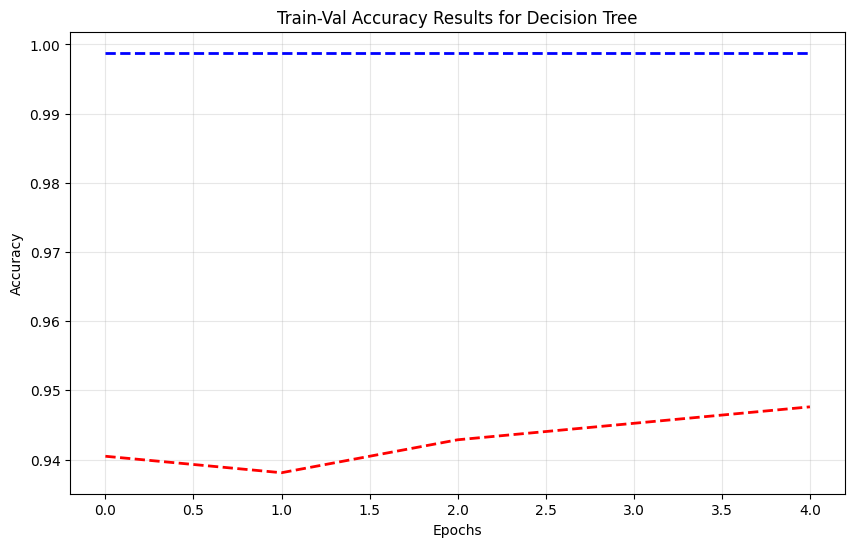

{'dataset': 'spam_assassin_stemmed_tfidf', 'model': 'Decision Tree', 'type': 'normal', 'metrics': {'accuracy': 0.9333333333333333, 'weighted_precision': 0.9333333333333333, 'wighted_recall': 0.9333333333333333, 'weighted_f1': 0.9333333333333333, 'macro_precision': 0.9241701271568956, 'macro_recall': 0.9241701271568956, 'macro_f1': 0.9241701271568956, 'roc_auc': 0.9241701271568955}, 'confusion_matrix': array([[269,  14],
       [ 14, 123]], dtype=int64)}


RandomForestClassifier classification report


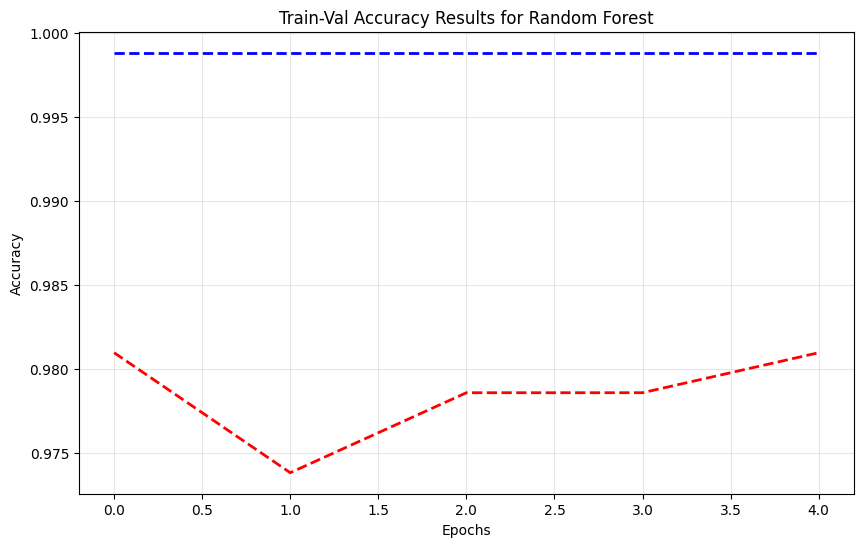

{'dataset': 'spam_assassin_stemmed_tfidf', 'model': 'Random Forest', 'type': 'normal', 'metrics': {'accuracy': 0.9857142857142858, 'weighted_precision': 0.9860108749382106, 'wighted_recall': 0.9857142857142858, 'weighted_f1': 0.9856292960770572, 'macro_precision': 0.9896193771626298, 'macro_recall': 0.9781021897810219, 'macro_f1': 0.9835612149044985, 'roc_auc': 0.9781021897810219}, 'confusion_matrix': array([[283,   0],
       [  6, 131]], dtype=int64)}


AdaBoostClassifier classification report


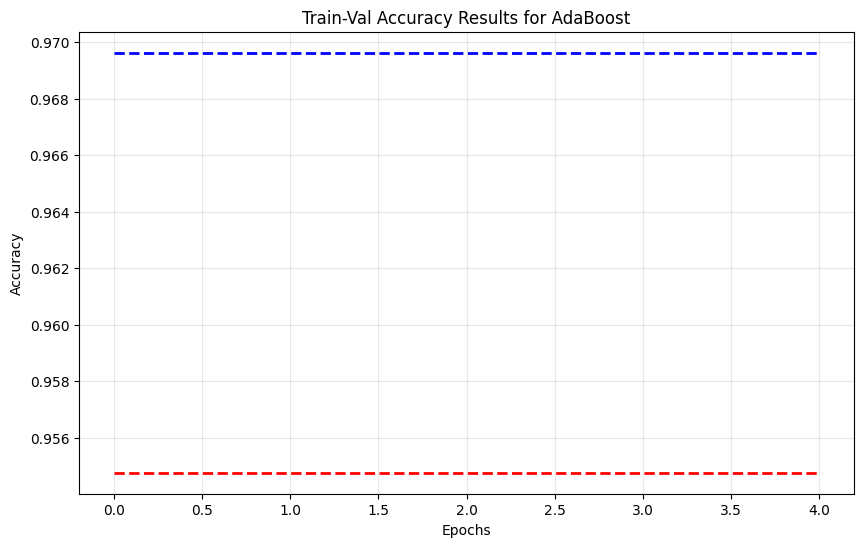

{'dataset': 'spam_assassin_stemmed_tfidf', 'model': 'AdaBoost', 'type': 'normal', 'metrics': {'accuracy': 0.9476190476190476, 'weighted_precision': 0.9474059713744291, 'wighted_recall': 0.9476190476190476, 'weighted_f1': 0.9474148333797456, 'macro_precision': 0.9435173299101411, 'macro_recall': 0.9366536844548761, 'macro_f1': 0.9399610136452241, 'roc_auc': 0.9366536844548761}, 'confusion_matrix': array([[274,   9],
       [ 13, 124]], dtype=int64)}


LogisticRegression classification report


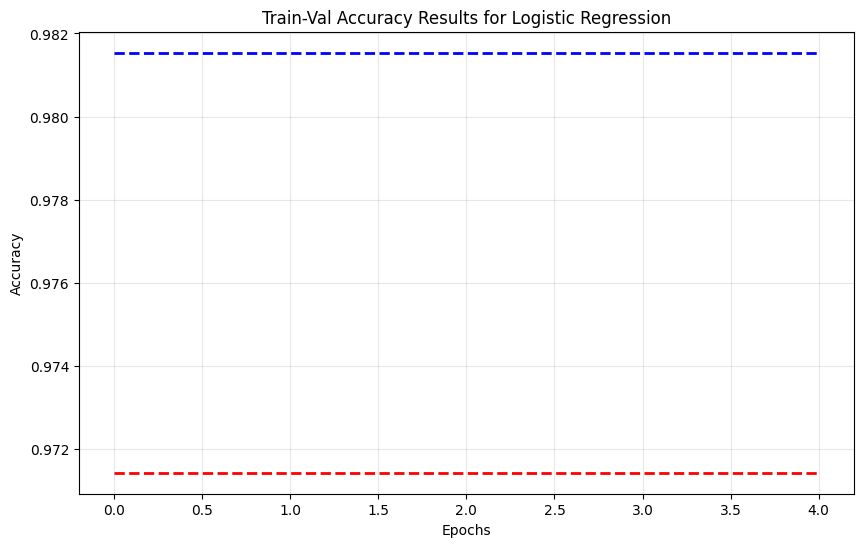

{'dataset': 'spam_assassin_stemmed_tfidf', 'model': 'Logistic Regression', 'type': 'normal', 'metrics': {'accuracy': 0.9547619047619048, 'weighted_precision': 0.9568531746031746, 'wighted_recall': 0.9547619047619048, 'weighted_f1': 0.9539252637336479, 'macro_precision': 0.9658333333333333, 'macro_recall': 0.9325397848907688, 'macro_f1': 0.946739993726265, 'roc_auc': 0.9325397848907688}, 'confusion_matrix': array([[282,   1],
       [ 18, 119]], dtype=int64)}


SGDClassifier classification report


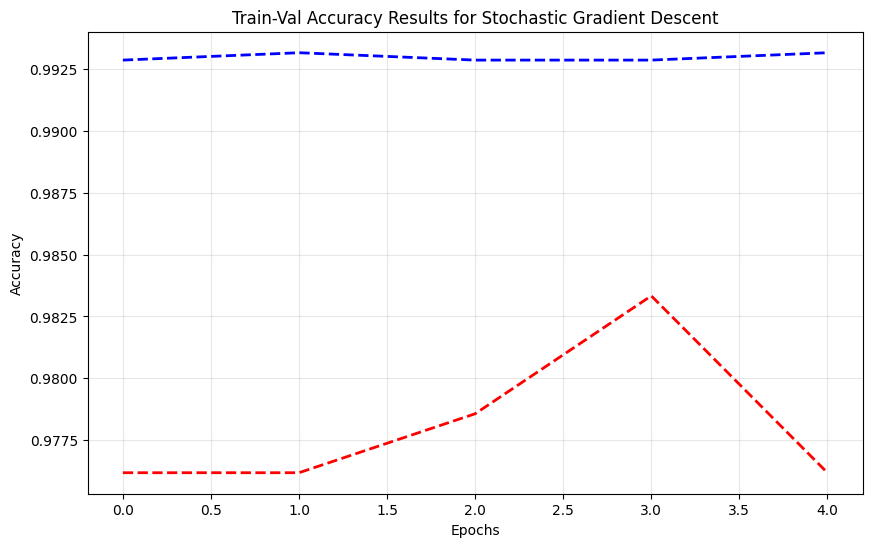

{'dataset': 'spam_assassin_stemmed_tfidf', 'model': 'Stochastic Gradient Descent', 'type': 'normal', 'metrics': {'accuracy': 0.9666666666666667, 'weighted_precision': 0.9672668476167441, 'wighted_recall': 0.9666666666666667, 'weighted_f1': 0.9663247053872055, 'macro_precision': 0.9716481685523097, 'macro_recall': 0.9526708106574502, 'macro_f1': 0.9613320707070707, 'roc_auc': 0.9526708106574502}, 'confusion_matrix': array([[281,   2],
       [ 12, 125]], dtype=int64)}


Perceptron classification report


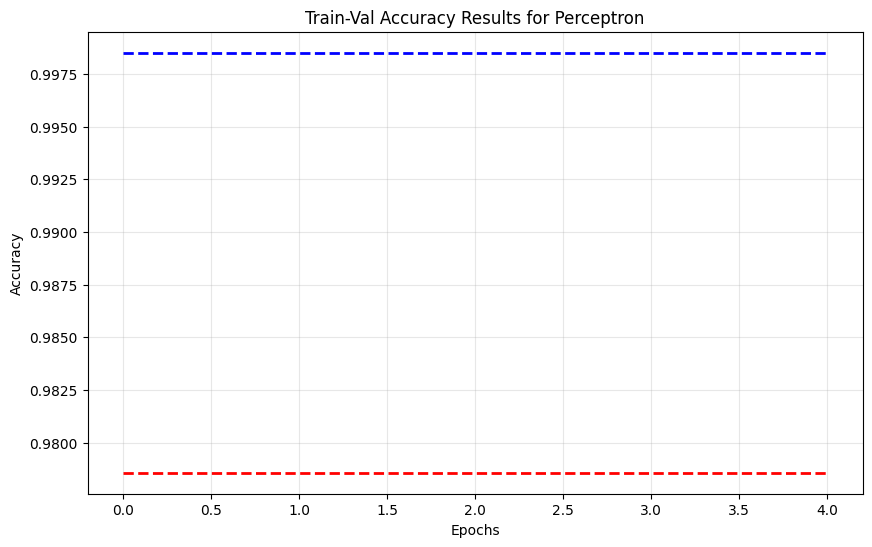

{'dataset': 'spam_assassin_stemmed_tfidf', 'model': 'Perceptron', 'type': 'normal', 'metrics': {'accuracy': 0.9761904761904762, 'weighted_precision': 0.9761904761904762, 'wighted_recall': 0.9761904761904762, 'weighted_f1': 0.9761904761904762, 'macro_precision': 0.9729179025560342, 'macro_recall': 0.9729179025560342, 'macro_f1': 0.9729179025560342, 'roc_auc': 0.9729179025560343}, 'confusion_matrix': array([[278,   5],
       [  5, 132]], dtype=int64)}


PassiveAggressiveClassifier classification report


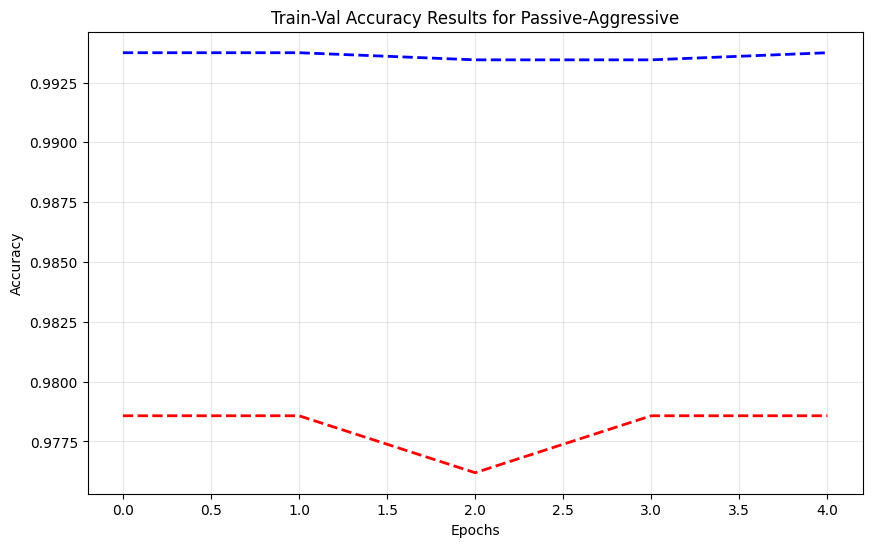

{'dataset': 'spam_assassin_stemmed_tfidf', 'model': 'Passive-Aggressive', 'type': 'normal', 'metrics': {'accuracy': 0.9738095238095238, 'weighted_precision': 0.9747894395853579, 'wighted_recall': 0.9738095238095238, 'weighted_f1': 0.9735114634845113, 'macro_precision': 0.9812925170068028, 'macro_recall': 0.9598540145985401, 'macro_f1': 0.9695553900798017, 'roc_auc': 0.9598540145985401}, 'confusion_matrix': array([[283,   0],
       [ 11, 126]], dtype=int64)}


SVC classification report


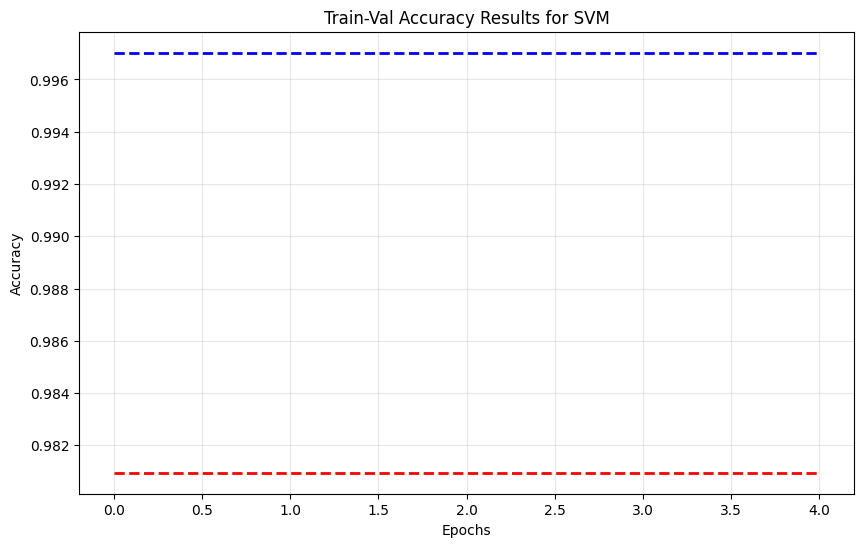

{'dataset': 'spam_assassin_stemmed_tfidf', 'model': 'SVM', 'type': 'normal', 'metrics': {'accuracy': 0.9738095238095238, 'weighted_precision': 0.9747894395853579, 'wighted_recall': 0.9738095238095238, 'weighted_f1': 0.9735114634845113, 'macro_precision': 0.9812925170068028, 'macro_recall': 0.9598540145985401, 'macro_f1': 0.9695553900798017, 'roc_auc': 0.9598540145985401}, 'confusion_matrix': array([[283,   0],
       [ 11, 126]], dtype=int64)}


KNeighborsClassifier classification report


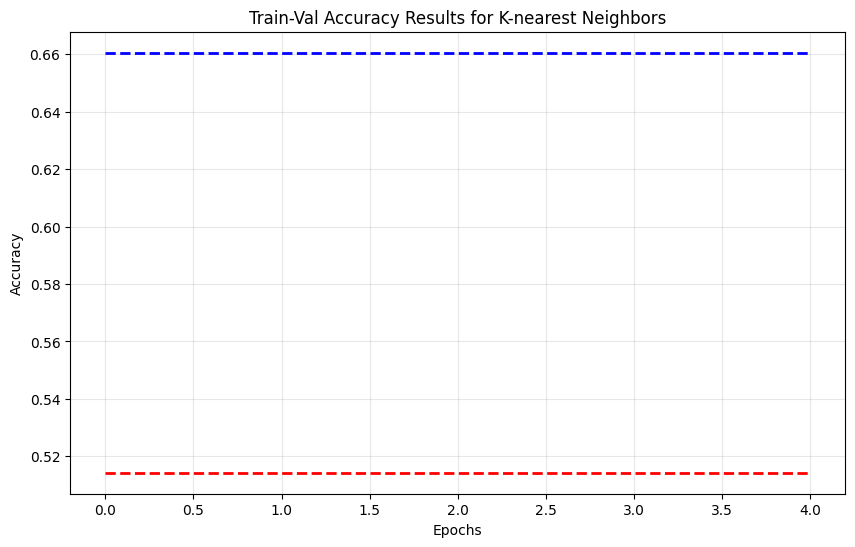

{'dataset': 'spam_assassin_stemmed_tfidf', 'model': 'K-nearest Neighbors', 'type': 'normal', 'metrics': {'accuracy': 0.5261904761904762, 'weighted_precision': 0.8068098072562359, 'wighted_recall': 0.5261904761904762, 'weighted_f1': 0.4974028717200887, 'macro_precision': 0.7038690476190477, 'macro_recall': 0.6484098939929328, 'macro_f1': 0.5185234257536393, 'roc_auc': 0.6484098939929328}, 'confusion_matrix': array([[ 84, 199],
       [  0, 137]], dtype=int64)}


MLPClassifier classification report


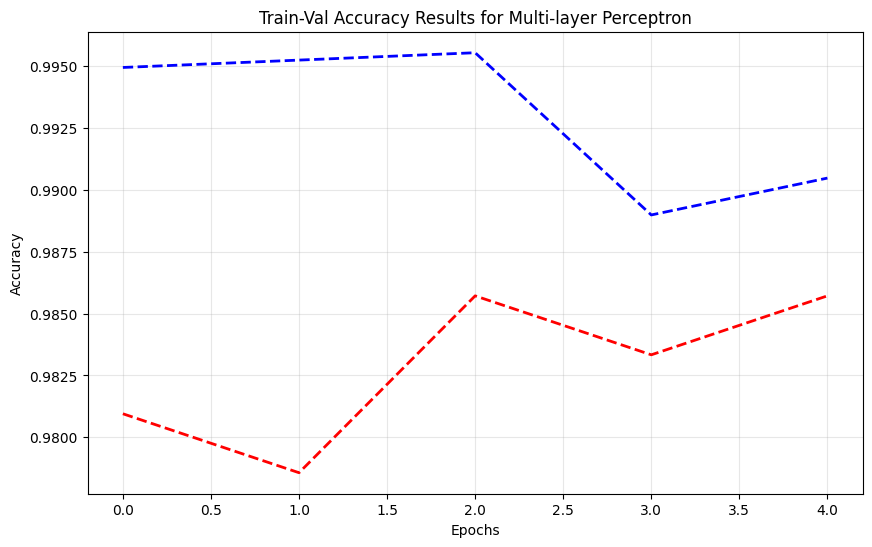

{'dataset': 'spam_assassin_stemmed_tfidf', 'model': 'Multi-layer Perceptron', 'type': 'normal', 'metrics': {'accuracy': 0.9809523809523809, 'weighted_precision': 0.9810082698034283, 'wighted_recall': 0.9809523809523809, 'weighted_f1': 0.9808781212289984, 'macro_precision': 0.982028241335045, 'macro_recall': 0.9745686208764283, 'macro_f1': 0.978167641325536, 'roc_auc': 0.9745686208764281}, 'confusion_matrix': array([[281,   2],
       [  6, 131]], dtype=int64)}




In [21]:
train_and_evaluate_model(spam_assassin_stemming_tfidf, csv_file["Is_spam"], "spam_assassin_stemmed_tfidf", model)
del spam_assassin_stemming_tfidf
del spam_assassin_stemming
model = None

## Lemmatizing + CountVectorizer

In [22]:
model = get_classification_models()

In [23]:
spam_assassin_lemmatizing = preprocessed_data.apply(preprocessing.lemmatizing)
spam_assassin_lemmatizing_countvec = preprocessing.vectorizing(spam_assassin_lemmatizing, "countvectorizer")

spam_assassin_lemmatized_countvec classification report
MultinomialNB classification report
BernoulliNB classification report


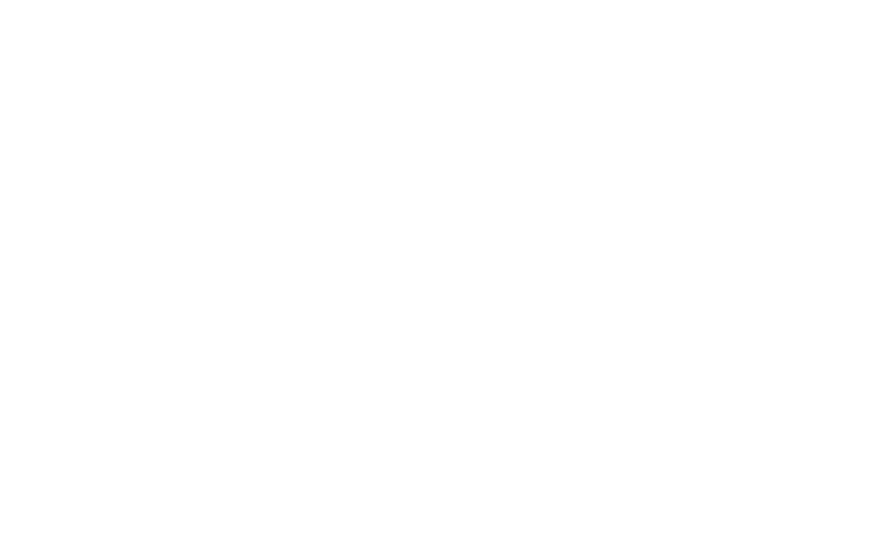

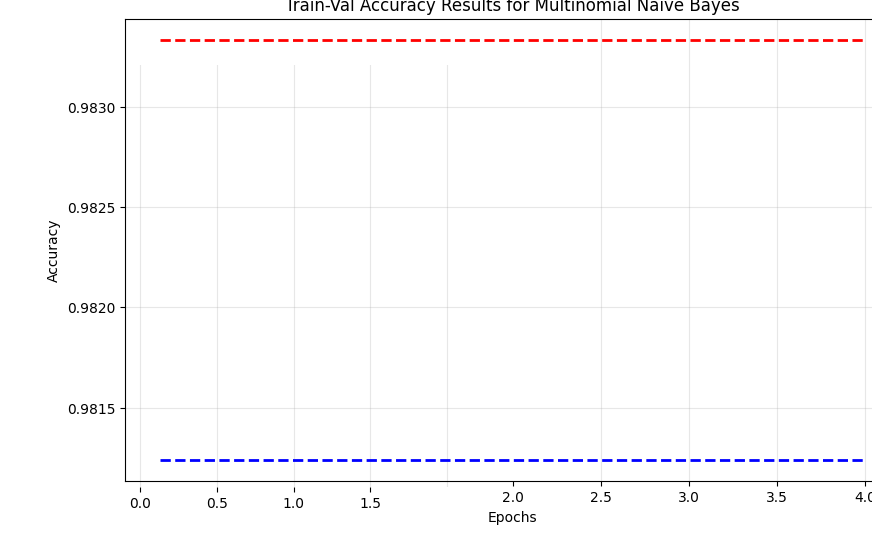

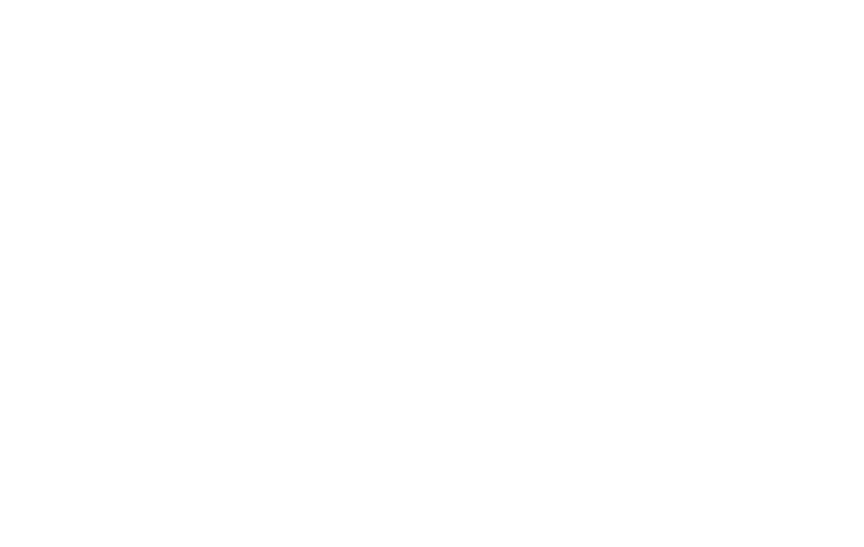

{'dataset': 'spam_assassin_lemmatized_countvec', 'model': 'Multinomial Naive Bayes', 'type': 'normal', 'metrics': {'accuracy': 0.9595238095238096, 'weighted_precision': 0.9598081784083496, 'wighted_recall': 0.9595238095238096, 'weighted_f1': 0.9591532481737567, 'macro_precision': 0.9621147260273972, 'macro_recall': 0.9454876067163602, 'macro_f1': 0.9531419196062346, 'roc_auc': 0.9454876067163601}, 'confusion_matrix': array([[279,   4],
       [ 13, 124]], dtype=int64)}




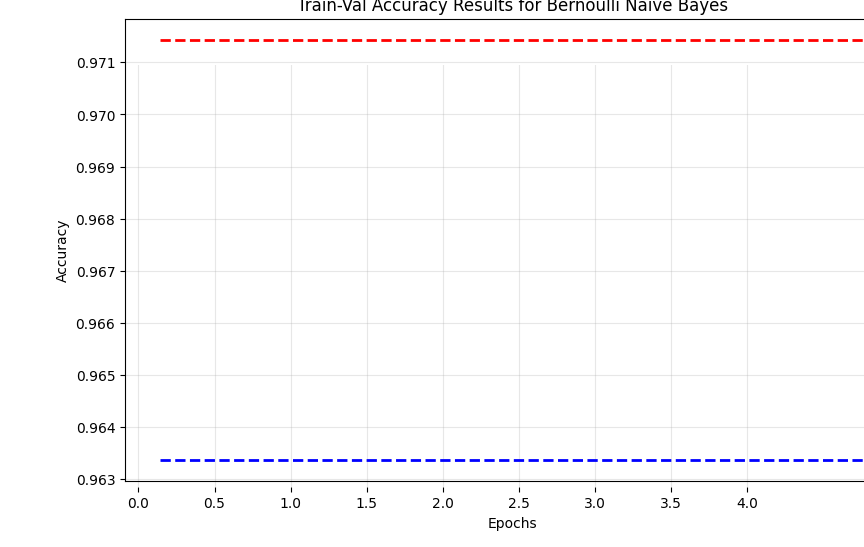

{'dataset': 'spam_assassin_lemmatized_countvec', 'model': 'Bernoulli Naive Bayes', 'type': 'normal', 'metrics': {'accuracy': 0.9404761904761905, 'weighted_precision': 0.9419603174603175, 'wighted_recall': 0.9404761904761905, 'weighted_f1': 0.9393753470179577, 'macro_precision': 0.9483333333333334, 'macro_recall': 0.9162905264243894, 'macro_f1': 0.9299210443766643, 'roc_auc': 0.9162905264243892}, 'confusion_matrix': array([[279,   4],
       [ 21, 116]], dtype=int64)}


DecisionTreeClassifier classification report


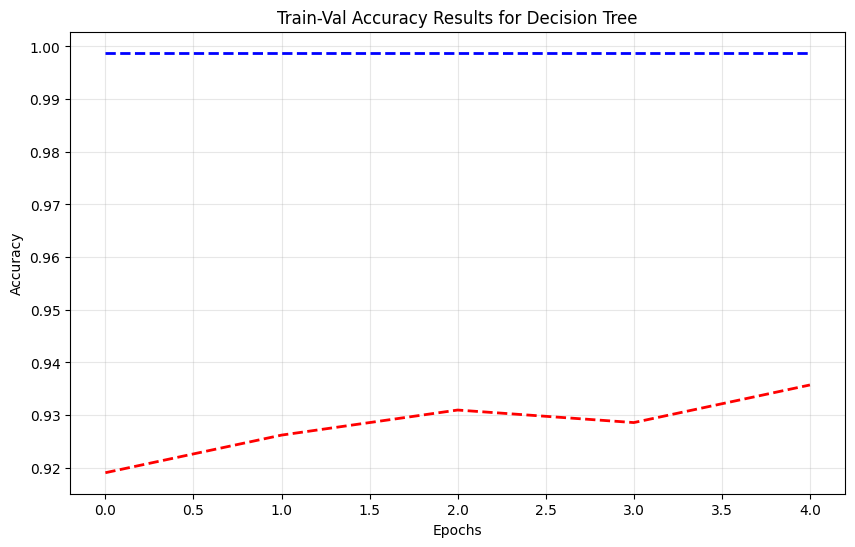

{'dataset': 'spam_assassin_lemmatized_countvec', 'model': 'Decision Tree', 'type': 'normal', 'metrics': {'accuracy': 0.9452380952380952, 'weighted_precision': 0.9451461218290133, 'wighted_recall': 0.9452380952380952, 'weighted_f1': 0.9451860896305341, 'macro_precision': 0.9384320629660314, 'macro_recall': 0.9367697505867787, 'macro_f1': 0.9375932709266043, 'roc_auc': 0.9367697505867788}, 'confusion_matrix': array([[272,  11],
       [ 12, 125]], dtype=int64)}


AdaBoostClassifier classification report


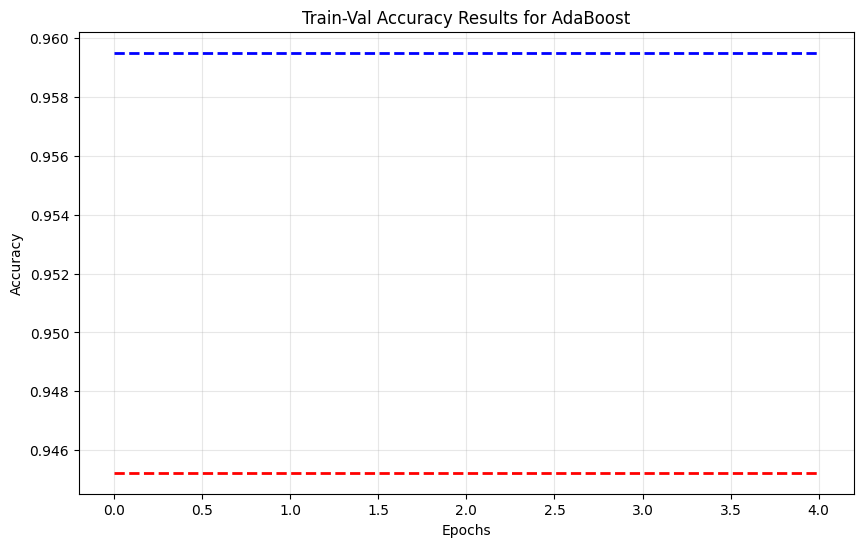

{'dataset': 'spam_assassin_lemmatized_countvec', 'model': 'AdaBoost', 'type': 'normal', 'metrics': {'accuracy': 0.9404761904761905, 'weighted_precision': 0.9403844585779517, 'wighted_recall': 0.9404761904761905, 'weighted_f1': 0.9399312473143482, 'macro_precision': 0.939640410958904, 'macro_recall': 0.9238219287611875, 'macro_f1': 0.9310910582444627, 'roc_auc': 0.9238219287611875}, 'confusion_matrix': array([[275,   8],
       [ 17, 120]], dtype=int64)}


LogisticRegression classification report


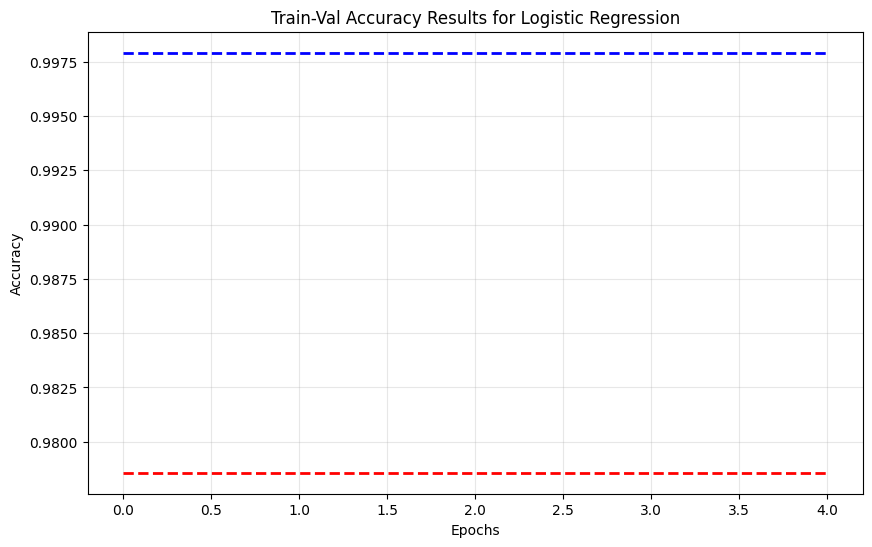

{'dataset': 'spam_assassin_lemmatized_countvec', 'model': 'Logistic Regression', 'type': 'normal', 'metrics': {'accuracy': 0.9857142857142858, 'weighted_precision': 0.9857105727281167, 'wighted_recall': 0.9857142857142858, 'weighted_f1': 0.9856869156113148, 'macro_precision': 0.9855750487329434, 'macro_recall': 0.981867890949421, 'macro_f1': 0.9836888980944489, 'roc_auc': 0.981867890949421}, 'confusion_matrix': array([[281,   2],
       [  4, 133]], dtype=int64)}


SVC classification report


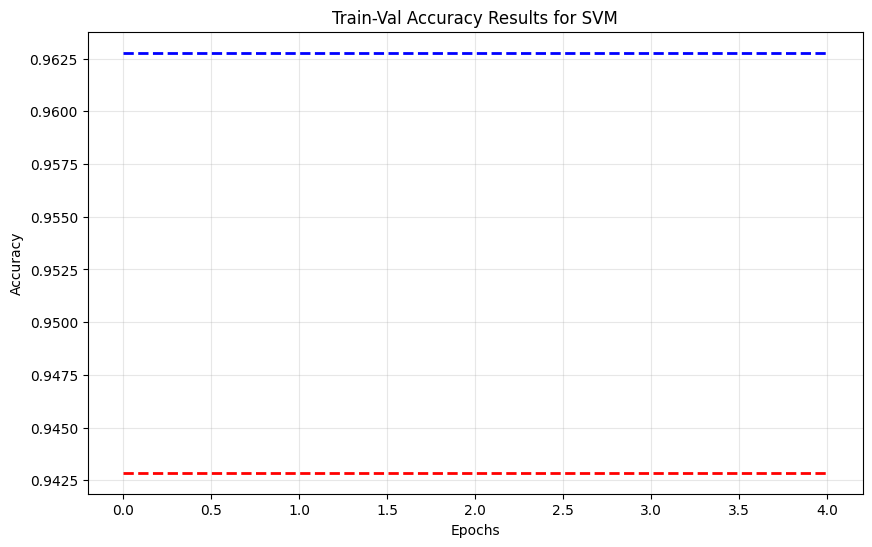

{'dataset': 'spam_assassin_lemmatized_countvec', 'model': 'SVM', 'type': 'normal', 'metrics': {'accuracy': 0.9261904761904762, 'weighted_precision': 0.9321903405236739, 'wighted_recall': 0.9261904761904762, 'weighted_f1': 0.9236208769221974, 'macro_precision': 0.9472934472934473, 'macro_recall': 0.8887441644528127, 'macro_f1': 0.9106842737094838, 'roc_auc': 0.8887441644528127}, 'confusion_matrix': array([[282,   1],
       [ 30, 107]], dtype=int64)}


KNeighborsClassifier classification report


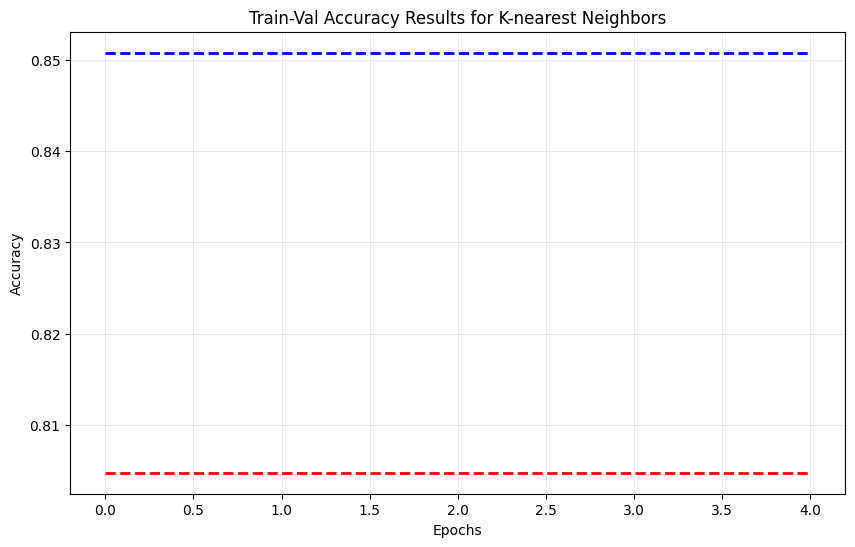

SGDClassifier classification report
{'dataset': 'spam_assassin_lemmatized_countvec', 'model': 'K-nearest Neighbors', 'type': 'normal', 'metrics': {'accuracy': 0.8, 'weighted_precision': 0.8672490073737947, 'wighted_recall': 0.8, 'weighted_f1': 0.8061754843517139, 'macro_precision': 0.8043108338060125, 'macro_recall': 0.8459415542544686, 'macro_f1': 0.7946162444113264, 'roc_auc': 0.8459415542544685}, 'confusion_matrix': array([[202,  81],
       [  3, 134]], dtype=int64)}




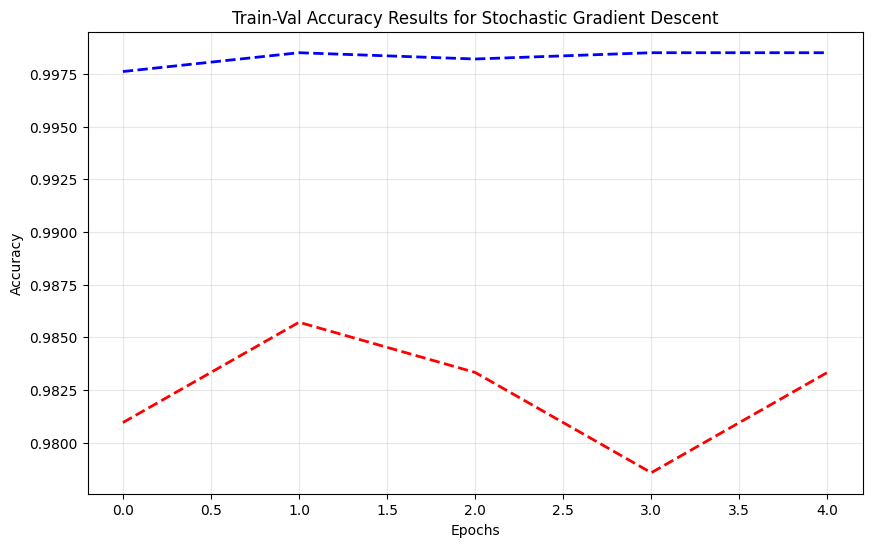

{'dataset': 'spam_assassin_lemmatized_countvec', 'model': 'Stochastic Gradient Descent', 'type': 'normal', 'metrics': {'accuracy': 0.9738095238095238, 'weighted_precision': 0.9737711293681444, 'wighted_recall': 0.9738095238095238, 'weighted_f1': 0.9737336015087492, 'macro_precision': 0.9728368646279094, 'macro_recall': 0.9673854169353382, 'macro_f1': 0.9700387162043853, 'roc_auc': 0.9673854169353382}, 'confusion_matrix': array([[279,   4],
       [  7, 130]], dtype=int64)}


Perceptron classification report


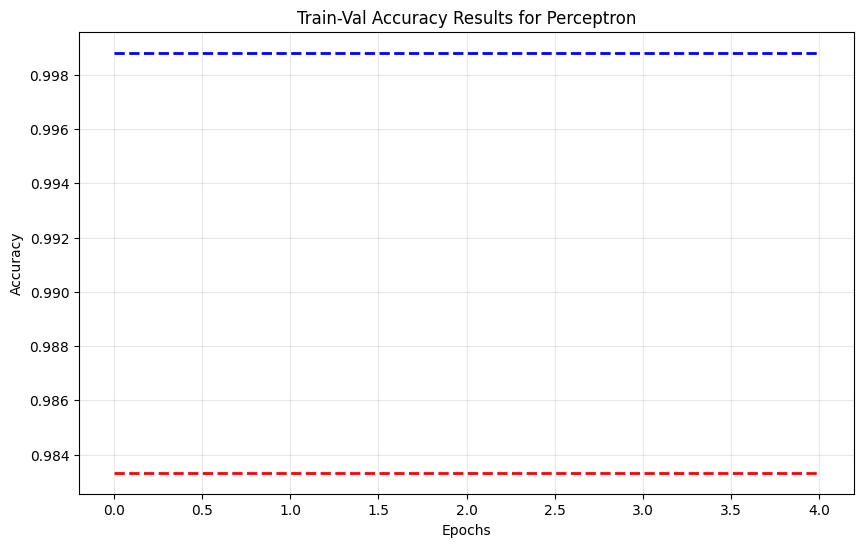

{'dataset': 'spam_assassin_lemmatized_countvec', 'model': 'Perceptron', 'type': 'normal', 'metrics': {'accuracy': 0.9738095238095238, 'weighted_precision': 0.9738708280105135, 'wighted_recall': 0.9738095238095238, 'weighted_f1': 0.9738339654445849, 'macro_precision': 0.9693956213382671, 'macro_recall': 0.9711511181037373, 'macro_f1': 0.9702654867256637, 'roc_auc': 0.9711511181037373}, 'confusion_matrix': array([[277,   6],
       [  5, 132]], dtype=int64)}


PassiveAggressiveClassifier classification report


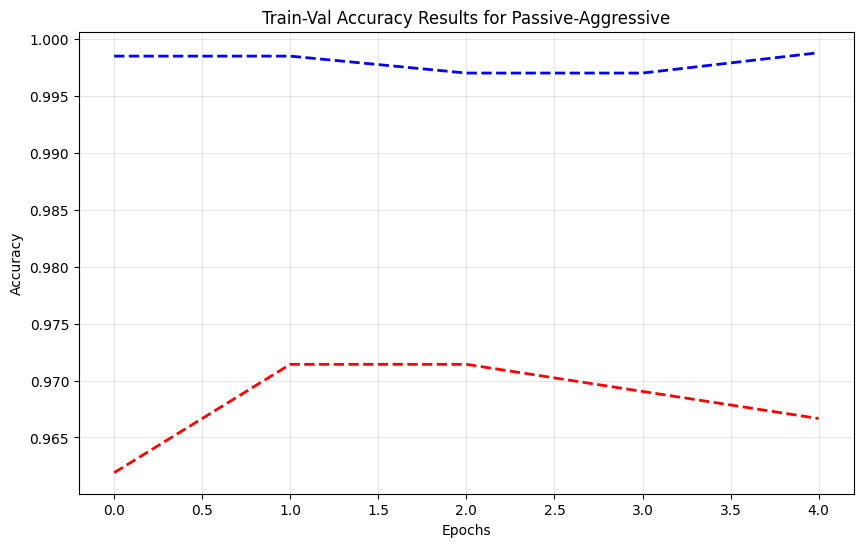

{'dataset': 'spam_assassin_lemmatized_countvec', 'model': 'Passive-Aggressive', 'type': 'normal', 'metrics': {'accuracy': 0.9523809523809523, 'weighted_precision': 0.9550273067447836, 'wighted_recall': 0.9523809523809523, 'weighted_f1': 0.9528642236223464, 'macro_precision': 0.9389286510314767, 'macro_recall': 0.9571329086172655, 'macro_f1': 0.9469844235187195, 'roc_auc': 0.9571329086172656}, 'confusion_matrix': array([[267,  16],
       [  4, 133]], dtype=int64)}


RandomForestClassifier classification report


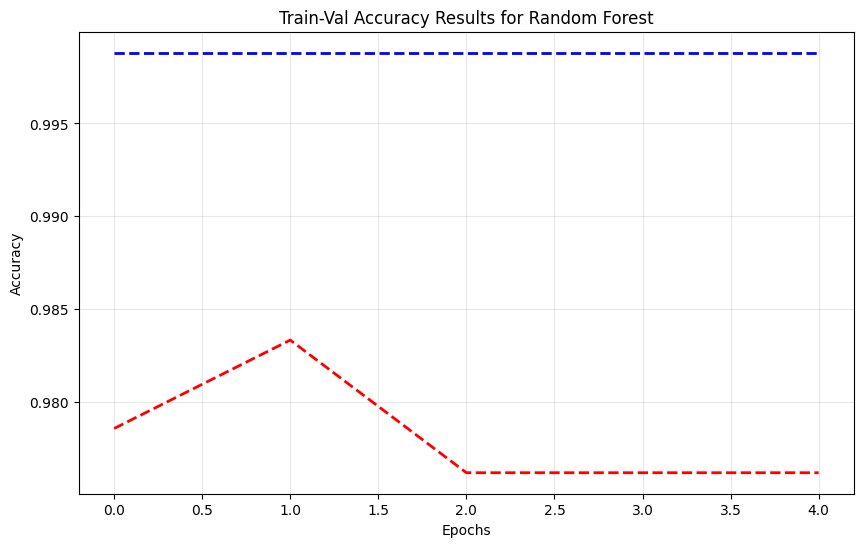

{'dataset': 'spam_assassin_lemmatized_countvec', 'model': 'Random Forest', 'type': 'normal', 'metrics': {'accuracy': 0.9809523809523809, 'weighted_precision': 0.9809301030353662, 'wighted_recall': 0.9809523809523809, 'weighted_f1': 0.9809158874817532, 'macro_precision': 0.9801169590643275, 'macro_recall': 0.9764514714606278, 'macro_f1': 0.9782518641259321, 'roc_auc': 0.9764514714606279}, 'confusion_matrix': array([[280,   3],
       [  5, 132]], dtype=int64)}


MLPClassifier classification report


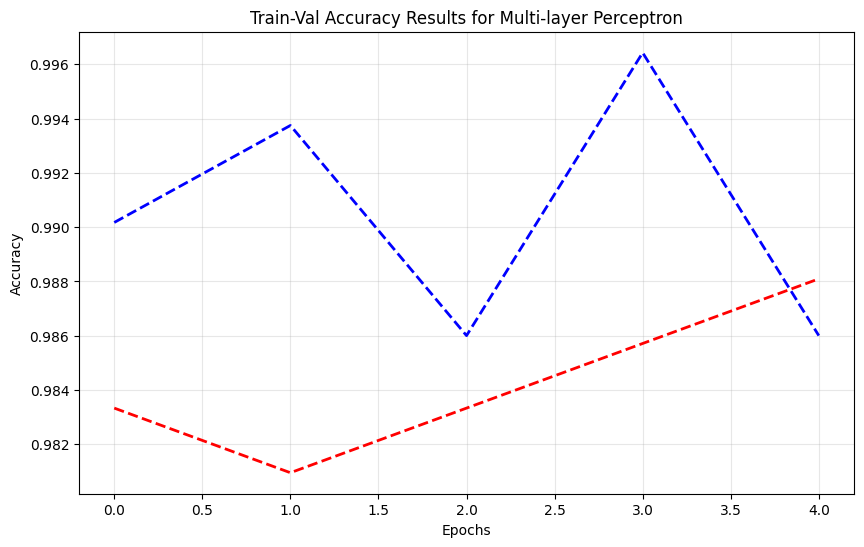

{'dataset': 'spam_assassin_lemmatized_countvec', 'model': 'Multi-layer Perceptron', 'type': 'normal', 'metrics': {'accuracy': 0.9809523809523809, 'weighted_precision': 0.9814760268368515, 'wighted_recall': 0.9809523809523809, 'weighted_f1': 0.9807986866120003, 'macro_precision': 0.9862542955326461, 'macro_recall': 0.9708029197080292, 'macro_f1': 0.977993764900055, 'roc_auc': 0.9708029197080292}, 'confusion_matrix': array([[283,   0],
       [  8, 129]], dtype=int64)}




In [24]:
train_and_evaluate_model(spam_assassin_lemmatizing_countvec, csv_file["Is_spam"], "spam_assassin_lemmatized_countvec", model)
del spam_assassin_lemmatizing_countvec
model = None

## Lemmatizing + TF-IDF

In [25]:
model = get_classification_models()

In [26]:
spam_assassin_lemmatizing_tfidf = preprocessing.vectorizing(spam_assassin_lemmatizing, "tfidf")

spam_assassin_lemmatized_tfidf classification report
MultinomialNB classification report
BernoulliNB classification report


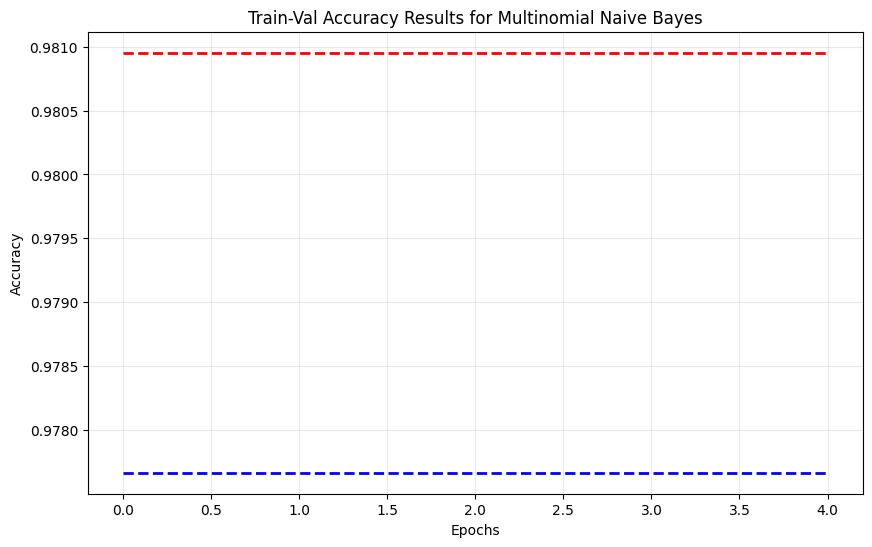

{'dataset': 'spam_assassin_lemmatized_tfidf', 'model': 'Multinomial Naive Bayes', 'type': 'normal', 'metrics': {'accuracy': 0.9547619047619048, 'weighted_precision': 0.9556861585087392, 'wighted_recall': 0.9547619047619048, 'weighted_f1': 0.9541431397961682, 'macro_precision': 0.9608761987794245, 'macro_recall': 0.936305486059168, 'macro_f1': 0.9471939332578961, 'roc_auc': 0.936305486059168}, 'confusion_matrix': array([[280,   3],
       [ 16, 121]], dtype=int64)}


{'dataset': 'spam_assassin_lemmatized_tfidf', 'model': 'Bernoulli Naive Bayes', 'type': 'normal', 'metrics': {'accuracy': 0.9404761904761905, 'weighted_precision': 0.9419603174603175, 'wighted_recall': 0.9404761904761905, 'weighted_f1': 0.9393753470179577, 'macro_precision': 0.9483333333333334, 'macro_recall': 0.9162905264243894, 'macro_f1': 0.9299210443766643, 'roc_auc': 0.9162905264243892}, 'confusion_matrix': array([[279,   4],
       [ 21, 116]], dtype=int64)}


DecisionTreeClassifier classification report


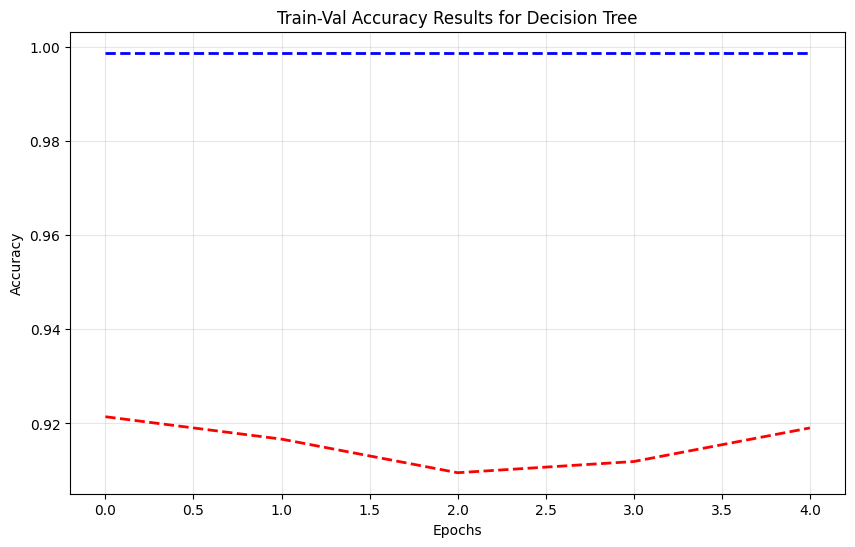

{'dataset': 'spam_assassin_lemmatized_tfidf', 'model': 'Decision Tree', 'type': 'normal', 'metrics': {'accuracy': 0.9380952380952381, 'weighted_precision': 0.9380952380952381, 'wighted_recall': 0.9380952380952381, 'weighted_f1': 0.9380952380952381, 'macro_precision': 0.9295865466456887, 'macro_recall': 0.9295865466456887, 'macro_f1': 0.9295865466456887, 'roc_auc': 0.9295865466456887}, 'confusion_matrix': array([[270,  13],
       [ 13, 124]], dtype=int64)}


RandomForestClassifier classification report


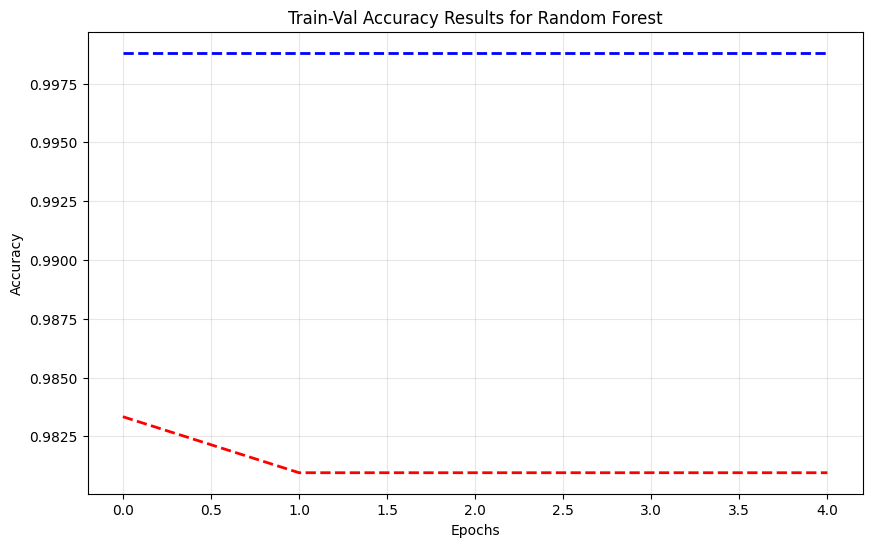

{'dataset': 'spam_assassin_lemmatized_tfidf', 'model': 'Random Forest', 'type': 'normal', 'metrics': {'accuracy': 0.9857142857142858, 'weighted_precision': 0.9858085981504284, 'wighted_recall': 0.9857142857142858, 'weighted_f1': 0.9856585909217489, 'macro_precision': 0.9875298001100312, 'macro_recall': 0.9799850403652215, 'macro_f1': 0.9836257309941521, 'roc_auc': 0.9799850403652215}, 'confusion_matrix': array([[282,   1],
       [  5, 132]], dtype=int64)}


AdaBoostClassifier classification report


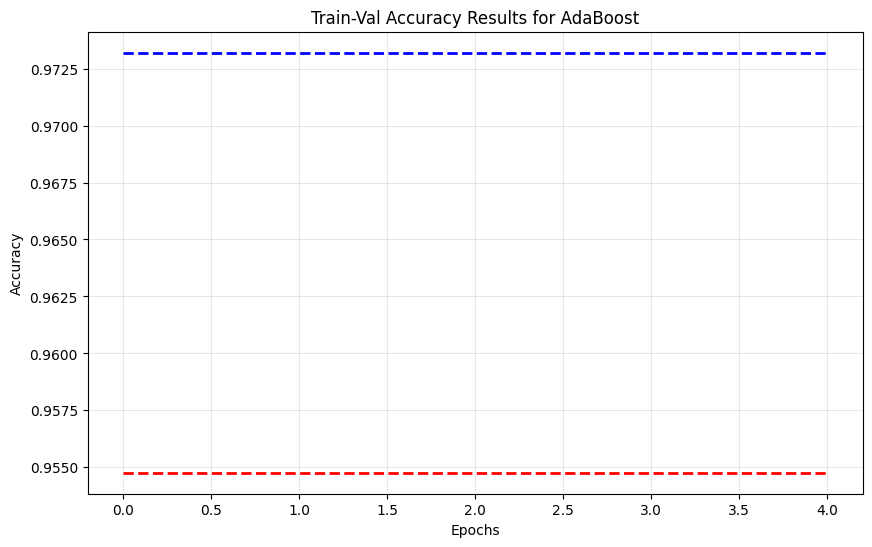

{'dataset': 'spam_assassin_lemmatized_tfidf', 'model': 'AdaBoost', 'type': 'normal', 'metrics': {'accuracy': 0.9404761904761905, 'weighted_precision': 0.9405991659691938, 'wighted_recall': 0.9404761904761905, 'weighted_f1': 0.9405317396467839, 'macro_precision': 0.9316219549799569, 'macro_recall': 0.9332361816821851, 'macro_f1': 0.9324215607401448, 'roc_auc': 0.9332361816821853}, 'confusion_matrix': array([[270,  13],
       [ 12, 125]], dtype=int64)}


LogisticRegression classification report


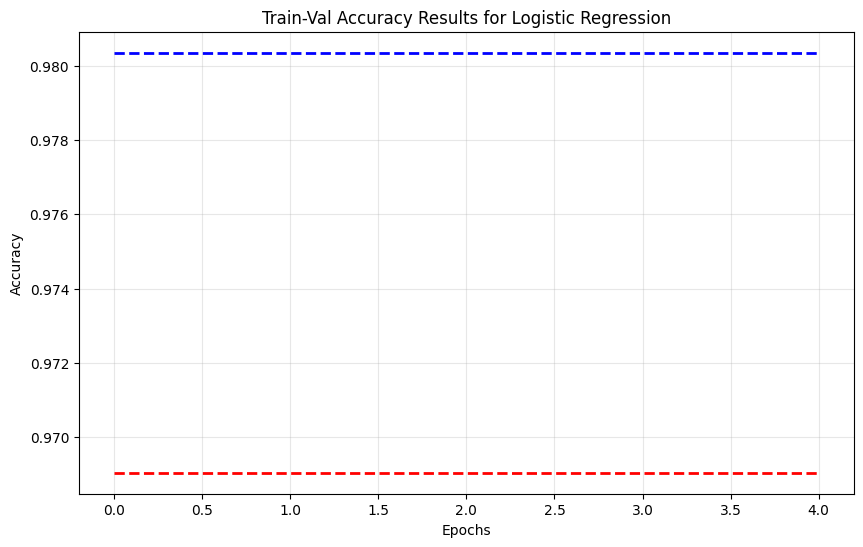

{'dataset': 'spam_assassin_lemmatized_tfidf', 'model': 'Logistic Regression', 'type': 'normal', 'metrics': {'accuracy': 0.9547619047619048, 'weighted_precision': 0.9568531746031746, 'wighted_recall': 0.9547619047619048, 'weighted_f1': 0.9539252637336479, 'macro_precision': 0.9658333333333333, 'macro_recall': 0.9325397848907688, 'macro_f1': 0.946739993726265, 'roc_auc': 0.9325397848907688}, 'confusion_matrix': array([[282,   1],
       [ 18, 119]], dtype=int64)}


SGDClassifier classification report


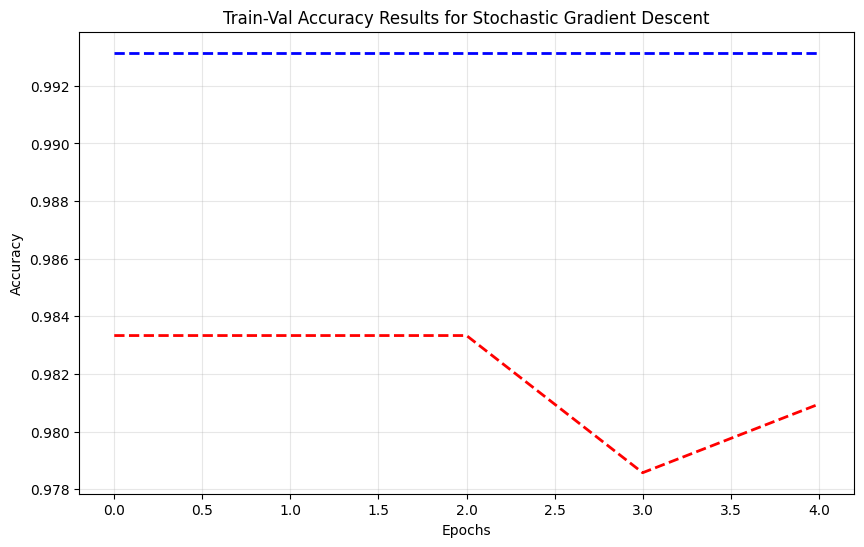

{'dataset': 'spam_assassin_lemmatized_tfidf', 'model': 'Stochastic Gradient Descent', 'type': 'normal', 'metrics': {'accuracy': 0.969047619047619, 'weighted_precision': 0.9699087571536552, 'wighted_recall': 0.969047619047619, 'weighted_f1': 0.9686953659362406, 'macro_precision': 0.9756235827664399, 'macro_recall': 0.954437595109747, 'macro_f1': 0.9640200064579475, 'roc_auc': 0.954437595109747}, 'confusion_matrix': array([[282,   1],
       [ 12, 125]], dtype=int64)}


Perceptron classification report


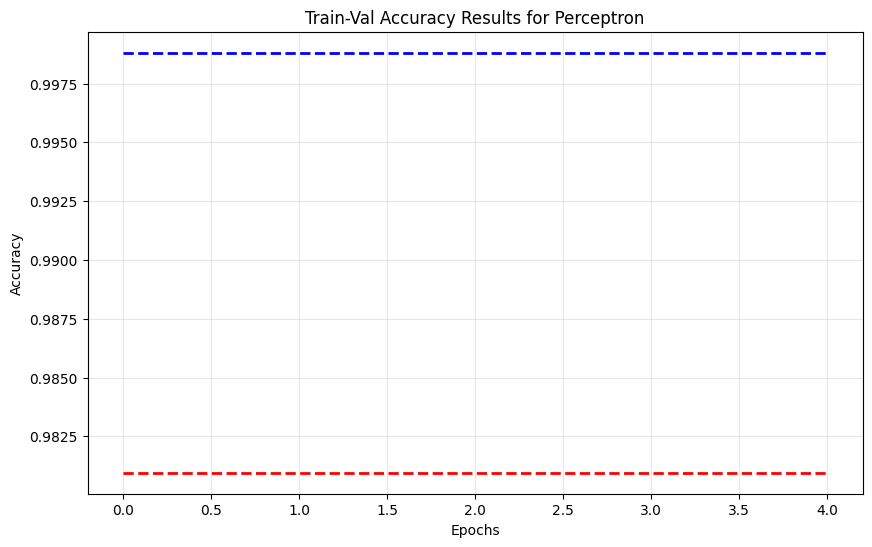

{'dataset': 'spam_assassin_lemmatized_tfidf', 'model': 'Perceptron', 'type': 'normal', 'metrics': {'accuracy': 0.9880952380952381, 'weighted_precision': 0.9880853749950684, 'wighted_recall': 0.9880952380952381, 'weighted_f1': 0.9880839325283769, 'macro_precision': 0.9873653686826844, 'macro_recall': 0.9855175259859172, 'macro_f1': 0.986433319766653, 'roc_auc': 0.9855175259859172}, 'confusion_matrix': array([[281,   2],
       [  3, 134]], dtype=int64)}


PassiveAggressiveClassifier classification report


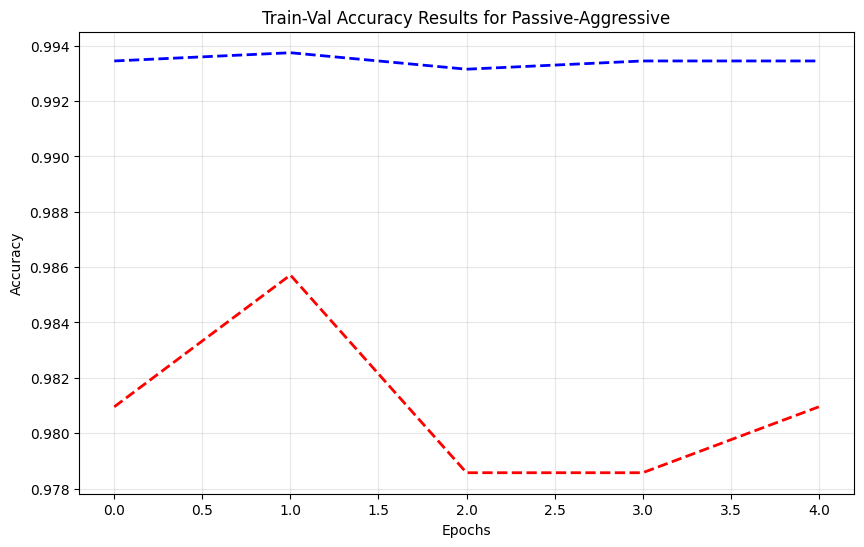

{'dataset': 'spam_assassin_lemmatized_tfidf', 'model': 'Passive-Aggressive', 'type': 'normal', 'metrics': {'accuracy': 0.969047619047619, 'weighted_precision': 0.9704070141570141, 'wighted_recall': 0.969047619047619, 'weighted_f1': 0.9686242535447467, 'macro_precision': 0.9780405405405406, 'macro_recall': 0.9525547445255474, 'macro_f1': 0.9638695332817184, 'roc_auc': 0.9525547445255474}, 'confusion_matrix': array([[283,   0],
       [ 13, 124]], dtype=int64)}


SVC classification report


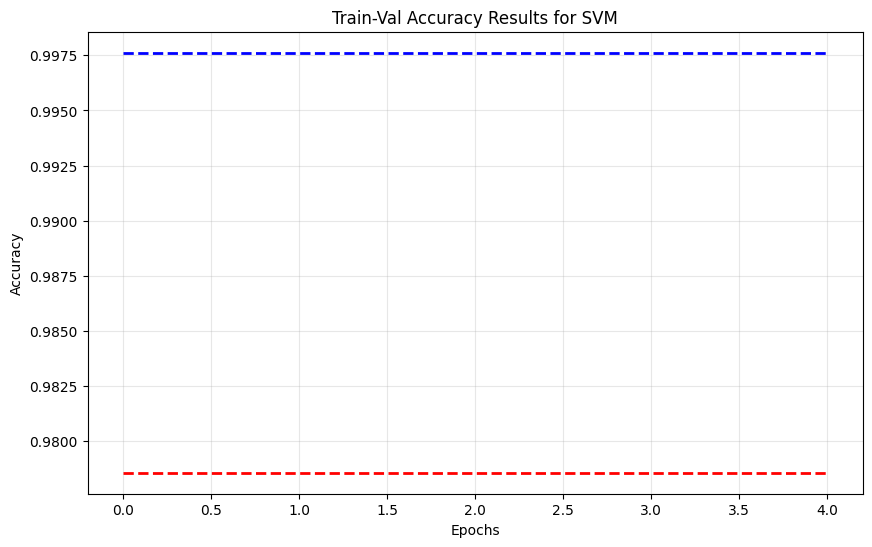

{'dataset': 'spam_assassin_lemmatized_tfidf', 'model': 'SVM', 'type': 'normal', 'metrics': {'accuracy': 0.9761904761904762, 'weighted_precision': 0.9770030879245897, 'wighted_recall': 0.9761904761904762, 'weighted_f1': 0.9759462181337183, 'macro_precision': 0.9829351535836177, 'macro_recall': 0.9635036496350364, 'macro_f1': 0.9723800505050506, 'roc_auc': 0.9635036496350364}, 'confusion_matrix': array([[283,   0],
       [ 10, 127]], dtype=int64)}


KNeighborsClassifier classification report


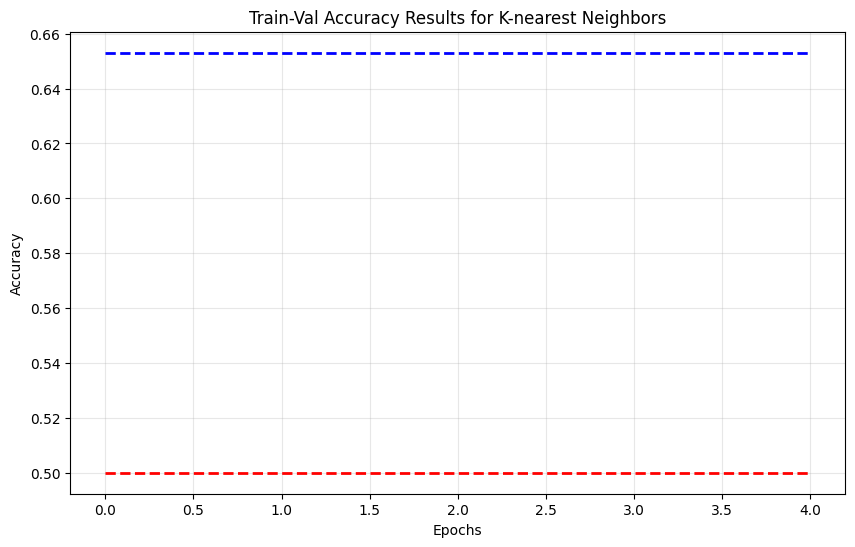

{'dataset': 'spam_assassin_lemmatized_tfidf', 'model': 'K-nearest Neighbors', 'type': 'normal', 'metrics': {'accuracy': 0.5142857142857142, 'weighted_precision': 0.8048596564725597, 'wighted_recall': 0.5142857142857142, 'weighted_f1': 0.4810731375469349, 'macro_precision': 0.7008797653958945, 'macro_recall': 0.6395759717314488, 'macro_f1': 0.5048429228599829, 'roc_auc': 0.6395759717314488}, 'confusion_matrix': array([[ 79, 204],
       [  0, 137]], dtype=int64)}


MLPClassifier classification report


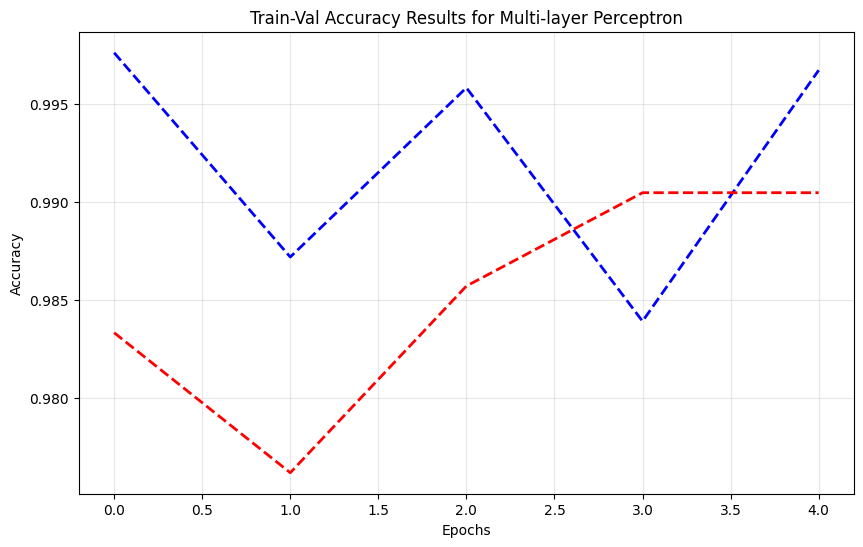

{'dataset': 'spam_assassin_lemmatized_tfidf', 'model': 'Multi-layer Perceptron', 'type': 'normal', 'metrics': {'accuracy': 0.9857142857142858, 'weighted_precision': 0.9858085981504284, 'wighted_recall': 0.9857142857142858, 'weighted_f1': 0.9856585909217489, 'macro_precision': 0.9875298001100312, 'macro_recall': 0.9799850403652215, 'macro_f1': 0.9836257309941521, 'roc_auc': 0.9799850403652215}, 'confusion_matrix': array([[282,   1],
       [  5, 132]], dtype=int64)}




In [27]:
train_and_evaluate_model(spam_assassin_lemmatizing_tfidf, csv_file["Is_spam"], "spam_assassin_lemmatized_tfidf", model)
del spam_assassin_lemmatizing_tfidf
del spam_assassin_lemmatizing
model = None

In [28]:
print(metric_results)

def convert(dic):
    dic["confusion_matrix"] = dic["confusion_matrix"].tolist()
    return dic

metric_results = list(map(convert, metric_results))

add_to_json_array("./spam_assassin_classification_report.json", metric_results, mode=JSON_WRITE_MODE)

[{'dataset': 'spam_assassin_stemmed_countvec', 'model': 'Bernoulli Naive Bayes', 'type': 'normal', 'metrics': {'accuracy': 0.9404761904761905, 'weighted_precision': 0.9419603174603175, 'wighted_recall': 0.9404761904761905, 'weighted_f1': 0.9393753470179577, 'macro_precision': 0.9483333333333334, 'macro_recall': 0.9162905264243894, 'macro_f1': 0.9299210443766643, 'roc_auc': 0.9162905264243892}, 'confusion_matrix': array([[279,   4],
       [ 21, 116]], dtype=int64)}, {'dataset': 'spam_assassin_stemmed_countvec', 'model': 'Multinomial Naive Bayes', 'type': 'normal', 'metrics': {'accuracy': 0.9571428571428572, 'weighted_precision': 0.9572555018970748, 'wighted_recall': 0.9571428571428572, 'weighted_f1': 0.9567970448770009, 'macro_precision': 0.9582833852793096, 'macro_recall': 0.9437208222640634, 'macro_f1': 0.9504859710251239, 'roc_auc': 0.9437208222640634}, 'confusion_matrix': array([[278,   5],
       [ 13, 124]], dtype=int64)}, {'dataset': 'spam_assassin_stemmed_countvec', 'model': 'D